In [13]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import graphviz
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import List

In [14]:
def load_and_merge_pdm(
    telemetry_path: str,
    errors_path: str,
    maint_path: str,
    failures_path: str,
    machines_path: str,
    *,
    floor_to_hour: bool = True,
    errors_as_counts: bool = True,
    maint_binary: bool = True,
    failures_binary: bool = True,
    include_maint_type_split: bool = True,
    corrective_window_hours: int = 6,
    include_model_onehot: bool = False,
    drop_raw_model: bool = False,
    telemetry_float_dtype: str = "float32",
    scale_continuous: bool = True,
) -> pd.DataFrame:
    """
    Merge Azure PdM CSVs into one hourly panel: one row per (machineID, datetime).

    Output columns (default):
      - telemetry: volt, rotate, pressure, vibration
      - machine attrs: model (string) and age (int)
      - errors: error1..error5 (counts per hour if errors_as_counts=True else binary)
      - maintenance:
          * if include_maint_type_split=True:
              maint_prev_comp{1..4}, maint_corr_comp{1..4}
          * else:
              maint_all_comp{1..4}
      - failures: fail_comp{1..4}

    Maintenance split rule:
      maintenance at time t for component c is "corr" if there exists a failure of c at time f
      with 0 <= (t - f) <= corrective_window_hours; else "prev".
    """


    def scale_continuous_features(df: pd.DataFrame, continuous_columns: List[str]) -> pd.DataFrame:
        """
        Scales continuous features (e.g., telemetry data) using StandardScaler.
        """
        scaler = StandardScaler()
        df[continuous_columns] = scaler.fit_transform(df[continuous_columns])
        return df

    tele = pd.read_csv(telemetry_path)
    errs = pd.read_csv(errors_path)
    maint = pd.read_csv(maint_path)
    fails = pd.read_csv(failures_path)
    machines = pd.read_csv(machines_path)

    if scale_continuous is True:
        tele = scale_continuous_features(tele, ['volt', 'rotate', 'pressure', 'vibration'])

    # Parse datetimes (hourly)
    for df in (tele, errs, maint, fails):
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
        if floor_to_hour:
            df["datetime"] = df["datetime"].dt.floor("h")

    # Base grid: telemetry + machine attributes
    base = tele.merge(machines, on="machineID", how="left")
    for c in ["volt", "rotate", "pressure", "vibration"]:
        if c in base.columns:
            base[c] = base[c].astype(telemetry_float_dtype)

    if include_model_onehot and "model" in base.columns:
        dummies = pd.get_dummies(base["model"], prefix="model", dtype=np.int8)
        base = pd.concat([base, dummies], axis=1)
        if drop_raw_model:
            base = base.drop(columns=["model"])

    base = base.sort_values(["machineID", "datetime"])
    base_idx = base.set_index(["machineID", "datetime"])

    # Errors wide: counts (or binary) per errorID per hour
    if not errs.empty:
        err_counts = errs.groupby(["machineID", "datetime", "errorID"]).size().reset_index(name="count")
        err_wide = err_counts.pivot_table(
            index=["machineID", "datetime"],
            columns="errorID",
            values="count",
            aggfunc="sum",
            fill_value=0,
        )
        for e in ["error1", "error2", "error3", "error4", "error5"]:
            if e not in err_wide.columns:
                err_wide[e] = 0
        err_wide = err_wide[["error1", "error2", "error3", "error4", "error5"]]
        err_wide = err_wide.astype(np.int16) if errors_as_counts else (err_wide > 0).astype(np.int8)
    else:
        err_wide = pd.DataFrame(index=base_idx.index)

    # Failures wide: binary per component per hour
    if not fails.empty:
        fail_counts = fails.groupby(["machineID", "datetime", "failure"]).size().reset_index(name="count")
        fail_wide = fail_counts.pivot_table(
            index=["machineID", "datetime"],
            columns="failure",
            values="count",
            aggfunc="sum",
            fill_value=0,
        )
        for c in ["comp1", "comp2", "comp3", "comp4"]:
            if c not in fail_wide.columns:
                fail_wide[c] = 0
        fail_wide = fail_wide[["comp1", "comp2", "comp3", "comp4"]]
        fail_wide = (fail_wide > 0).astype(np.int8) if failures_binary else fail_wide.astype(np.int16)
        fail_wide = fail_wide.add_prefix("fail_")
    else:
        fail_wide = pd.DataFrame(index=base_idx.index)

    # Maintenance wide: binary per component per hour, optionally split by type
    if not maint.empty:
        m = maint.copy()

        if include_maint_type_split:
            # Find most recent past failure on same (machineID, comp), then label corr if within window
            f = fails.rename(columns={"failure": "comp"})[["machineID", "datetime", "comp"]].copy()
            f = f.rename(columns={"datetime": "failure_time"})

            # merge_asof needs global sort by merge key
            m = m.sort_values(["datetime", "machineID", "comp"]).reset_index(drop=True)
            f = f.sort_values(["failure_time", "machineID", "comp"]).reset_index(drop=True)

            m2 = pd.merge_asof(
                m,
                f,
                left_on="datetime",
                right_on="failure_time",
                by=["machineID", "comp"],
                direction="backward",
                allow_exact_matches=True,
            )
            delta_h = (m2["datetime"] - m2["failure_time"]).dt.total_seconds() / 3600.0
            m2["maint_type"] = np.where(
                (~m2["failure_time"].isna()) & (delta_h >= 0) & (delta_h <= corrective_window_hours),
                "corr",
                "prev",
            )
            m = m2[["machineID", "datetime", "comp", "maint_type"]]
            types = ["prev", "corr"]
        else:
            m["maint_type"] = "all"
            m = m[["machineID", "datetime", "comp", "maint_type"]]
            types = ["all"]

        maint_counts = m.groupby(["machineID", "datetime", "maint_type", "comp"]).size().reset_index(name="count")
        maint_wide = maint_counts.pivot_table(
            index=["machineID", "datetime"],
            columns=["maint_type", "comp"],
            values="count",
            aggfunc="sum",
            fill_value=0,
        )

        # Flatten columns: maint_{type}_{comp}
        maint_wide.columns = [f"maint_{t}_{c}" for (t, c) in maint_wide.columns]

        # Ensure all component columns exist for each type
        for t in types:
            for c in ["comp1", "comp2", "comp3", "comp4"]:
                col = f"maint_{t}_{c}"
                if col not in maint_wide.columns:
                    maint_wide[col] = 0

        maint_wide = maint_wide[[f"maint_{t}_{c}" for t in types for c in ["comp1","comp2","comp3","comp4"]]]
        maint_wide = (maint_wide > 0).astype(np.int8) if maint_binary else maint_wide.astype(np.int16)
    else:
        maint_wide = pd.DataFrame(index=base_idx.index)

    # Join everything onto telemetry grid
    merged = base_idx.join(err_wide, how="left").join(maint_wide, how="left").join(fail_wide, how="left")
    merged = merged.fillna(0)

    # Re-cast event columns back to int (joins can upcast to float due to NaNs)
    event_cols: List[str] = []
    event_cols += [c for c in merged.columns if c in ["error1","error2","error3","error4","error5"]]
    event_cols += [c for c in merged.columns if c.startswith("maint_")]
    event_cols += [c for c in merged.columns if c.startswith("fail_")]
    for c in event_cols:
        if c.startswith("error") and errors_as_counts:
            merged[c] = merged[c].astype(np.int16)
        else:
            merged[c] = merged[c].astype(np.int8)

    merged = merged.reset_index().sort_values(["machineID", "datetime"]).reset_index(drop=True)
    return merged


def load_and_merge_pdm_from_dir(data_dir: str, **kwargs) -> pd.DataFrame:
    """Convenience wrapper assuming Kaggle filenames (PdM_*.csv) in one folder."""
    return load_and_merge_pdm(
        telemetry_path=os.path.join(data_dir, "PdM_telemetry.csv"),
        errors_path=os.path.join(data_dir, "PdM_errors.csv"),
        maint_path=os.path.join(data_dir, "PdM_maint.csv"),
        failures_path=os.path.join(data_dir, "PdM_failures.csv"),
        machines_path=os.path.join(data_dir, "PdM_machines.csv"),
        **kwargs,
    )

# Example usage:
# df = load_and_merge_pdm_from_dir("/path/to/kaggle/PdM", include_maint_type_split=True, corrective_window_hours=6)
# df_model1 = df[df["model"] == "model1"]  # if you want to split realizations by machine type


In [15]:
df = load_and_merge_pdm_from_dir(data_dir="./data")
df.head()

machineID            datetime      volt    rotate  pressure  vibration  \
0          1 2015-01-01 06:00:00  0.350769 -0.533491  1.105949   0.875673   
1          1 2015-01-01 07:00:00 -0.509282 -0.832626 -0.488578   0.564016   
2          1 2015-01-01 08:00:00  0.013680  1.532918 -2.318900  -1.155632   
3          1 2015-01-01 09:00:00 -0.536130 -1.907128  0.759358   0.137260   
4          1 2015-01-01 10:00:00 -0.849031 -0.213165  0.998127  -2.680361   

    model  age  error1  error2  ...  maint_prev_comp3  maint_prev_comp4  \
0  model3   18       0       0  ...                 0                 0   
1  model3   18       0       0  ...                 0                 0   
2  model3   18       0       0  ...                 0                 0   
3  model3   18       0       0  ...                 0                 0   
4  model3   18       0       0  ...                 0                 0   

   maint_corr_comp1  maint_corr_comp2  maint_corr_comp3  maint_corr_comp4  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   fail_comp1  fail_comp2  fail_comp3  fail_comp4  
0           0           0           0           0  
1           0           0           0           0  
2           0           0           0           0  
3           0           0           0           0  
4           0           0           0           0  

[5 rows x 25 columns]

In [10]:
# print("Maint hours:\n", pd.read_csv("./data/PdM_maint.csv", parse_dates=["datetime"])["datetime"].dt.hour.value_counts().sort_index())
# print("Fail hours:\n",  pd.read_csv("./data/PdM_failures.csv", parse_dates=["datetime"])["datetime"].dt.hour.value_counts().sort_index())
# print("Err hours:\n",   pd.read_csv("./data/PdM_errors.csv", parse_dates=["datetime"])["datetime"].dt.hour.value_counts().sort_index())

In [ ]:
def visualize_data(
    telemetry_path: str,
    errors_path: str,
    failures_path: str,
    maint_path: str,
    machines_path: str,
    machine_model: str = None,
    failure_type: str = None,
    window_hours: int = 48,
    n_examples: int = 3,
    ylim_sigma: int = 5,
    smooth_window: int = 6,
    scale: bool = True
):
    print("Loading data...")
    tele = pd.read_csv(telemetry_path, parse_dates=["datetime"])
    errors = pd.read_csv(errors_path, parse_dates=["datetime"])
    fails = pd.read_csv(failures_path, parse_dates=["datetime"])
    maint = pd.read_csv(maint_path, parse_dates=["datetime"])
    machines = pd.read_csv(machines_path)

    if machine_model:
        target_mids = machines[machines["model"] == machine_model]["machineID"]
        fails = fails[fails["machineID"].isin(target_mids)]
    
    if failure_type:
        fails = fails[fails["failure"] == failure_type]

    if fails.empty:
        print("No failures found.")
        return

    sample_failures = fails.sample(n=min(n_examples, len(fails)), random_state=12345678)
    sensor_cols = ["volt", "rotate", "pressure", "vibration"]

    for idx, row in sample_failures.iterrows():
        mid = row["machineID"]
        fail_dt = row["datetime"]
        fail_comp = row["failure"]
        model = machines[machines["machineID"]==mid]["model"].values[0]

        # --- DATA PREP ---
        # Get full history to calculate baseline statistics
        machine_tele = tele[tele["machineID"] == mid].copy().sort_values("datetime")
        
        # Calculate stats for this specific machine
        stats = {}
        for col in sensor_cols:
            mu = machine_tele[col].mean()
            sigma = machine_tele[col].std()
            stats[col] = {'mean': mu, 'std': sigma}
            
            # Apply Scaling if requested
            if scale:
                machine_tele[col] = (machine_tele[col] - mu) / sigma

            # Create Smooth Column (on top of whatever units we are using)
            machine_tele[f"{col}_smooth"] = machine_tele[col].rolling(window=smooth_window, center=True).mean()

        # Slice Window
        start_time = fail_dt - pd.Timedelta(hours=window_hours)
        end_time = fail_dt + pd.Timedelta(hours=window_hours)
        
        window_tele = machine_tele[machine_tele["datetime"].between(start_time, end_time)]
        window_errors = errors[(errors["machineID"] == mid) & (errors["datetime"].between(start_time, end_time))]
        window_maint = maint[(maint["machineID"] == mid) & (maint["datetime"].between(start_time, end_time))]

        if window_tele.empty: continue

        # --- PLOTTING ---
        unit_label = "Z-Score" if scale else "Raw Units"
        fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)
        fig.suptitle(
            f"Machine {mid} ({model}): {fail_comp} at {fail_dt}\n"
            f"Scale: {unit_label} (Fixed +/- {ylim_sigma}σ) | Trend: {smooth_window}h Avg", 
            fontsize=16
        )

        for i, sensor in enumerate(sensor_cols):
            ax = axes[i]
            
            # 1. Plot Raw & Smooth
            sns.lineplot(data=window_tele, x="datetime", y=sensor, ax=ax, color='gray', alpha=0.2, linewidth=0.8)
            sns.lineplot(data=window_tele, x="datetime", y=f"{sensor}_smooth", ax=ax, color='tab:blue', linewidth=2.5)
            
            # 2. Smart Y-Axis Limits
            # If scale=True, center is 0. If scale=False, center is Mean.
            center = 0 if scale else stats[sensor]['mean']
            std_dev = 1 if scale else stats[sensor]['std']
            
            lower_limit = center - (ylim_sigma * std_dev)
            upper_limit = center + (ylim_sigma * std_dev)
            
            ax.set_ylim(lower_limit, upper_limit)

            # 3. Visual Guides (Normal Range = +/- 2 Sigma)
            norm_lower = center - (2 * std_dev)
            norm_upper = center + (2 * std_dev)
            ax.axhspan(norm_lower, norm_upper, color='green', alpha=0.05, label="Normal (2σ)")
            ax.axhline(center, color='green', linestyle=':', alpha=0.5)

            # 4. 6:00 AM Grid
            six_ams = pd.date_range(start=start_time, end=end_time, freq="D") + pd.Timedelta(hours=6)
            for t in six_ams:
                ax.axvline(t, color='gray', linestyle=':', alpha=0.3)

            # 5. Stacked Error Labels
            if not window_errors.empty:
                err_points = pd.merge_asof(
                    window_errors.sort_values('datetime'), 
                    window_tele[['datetime', f"{sensor}_smooth"]], 
                    on='datetime', direction='nearest'
                )
                
                # Markers
                ax.scatter(err_points['datetime'], err_points[f"{sensor}_smooth"], 
                           color='red', s=60, zorder=5, marker='X')

                # Text Labels
                for dt, group in err_points.groupby('datetime'):
                    y_val = group[f"{sensor}_smooth"].iloc[0]
                    if pd.notna(y_val) and lower_limit < y_val < upper_limit:
                        labels = sorted(group['errorID'].apply(lambda s: s.replace("error", "E")).unique())
                        label_text = " / ".join(labels)
                        
                        ax.text(
                            dt, y_val + (0.6 * std_dev), # Smart offset based on unit scale
                            label_text, 
                            color='red', fontweight='bold', fontsize=10, ha='center',
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                        )

            # 6. Maint / Failure
            for m_date in window_maint['datetime']:
                ax.axvline(m_date, color='green', linestyle='--', linewidth=2, label='Maint.')
            ax.axvline(fail_dt, color='red', linestyle='-', linewidth=2, label='FAILURE')

            ax.set_ylabel(f"{sensor.title()}\n({unit_label})")
            if i == 0:
                ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

        plt.tight_layout()
        plt.show()



=== Visualizing for model1 - comp1 ===
Loading data...


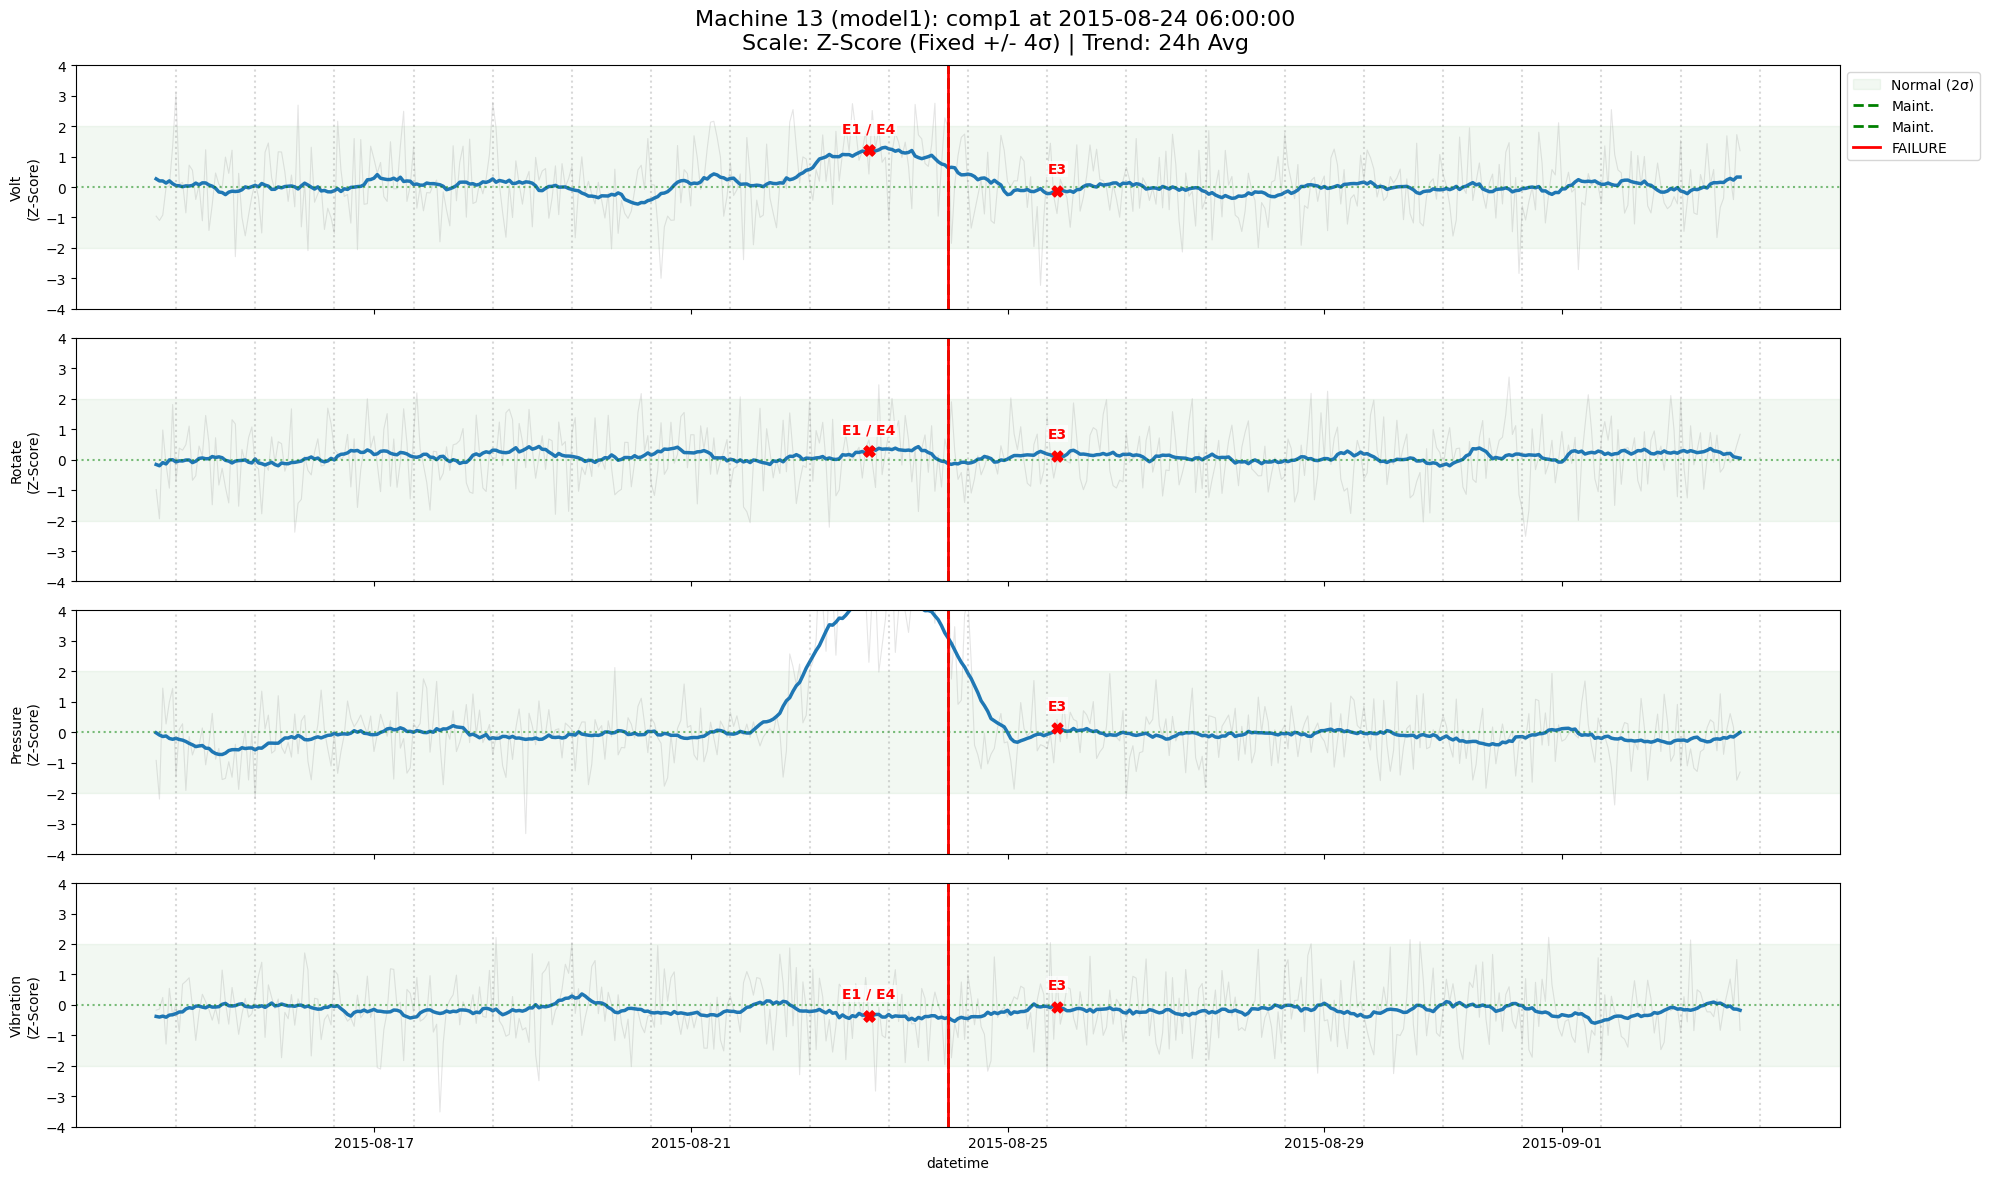



=== Visualizing for model1 - comp2 ===
Loading data...


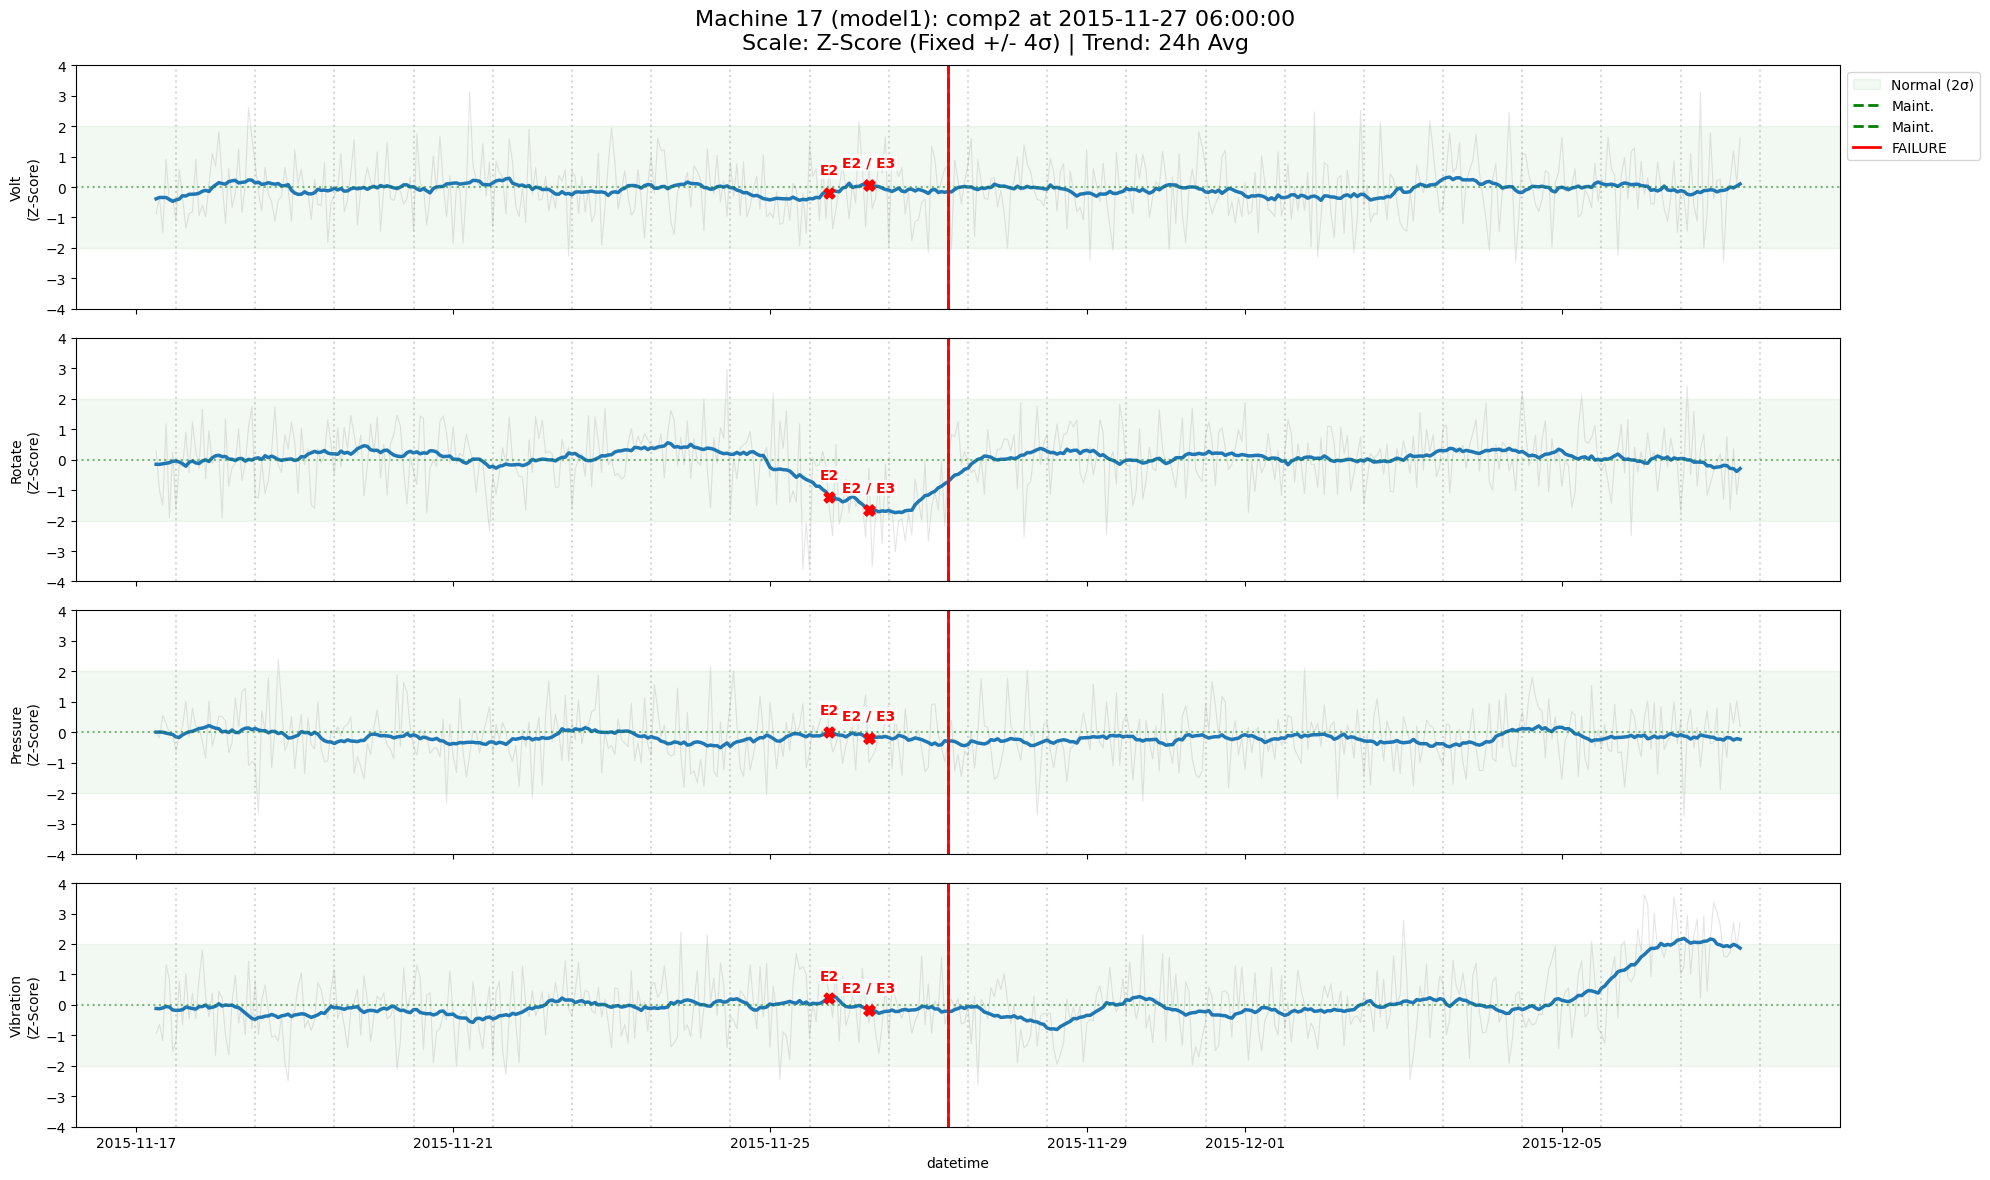



=== Visualizing for model1 - comp3 ===
Loading data...


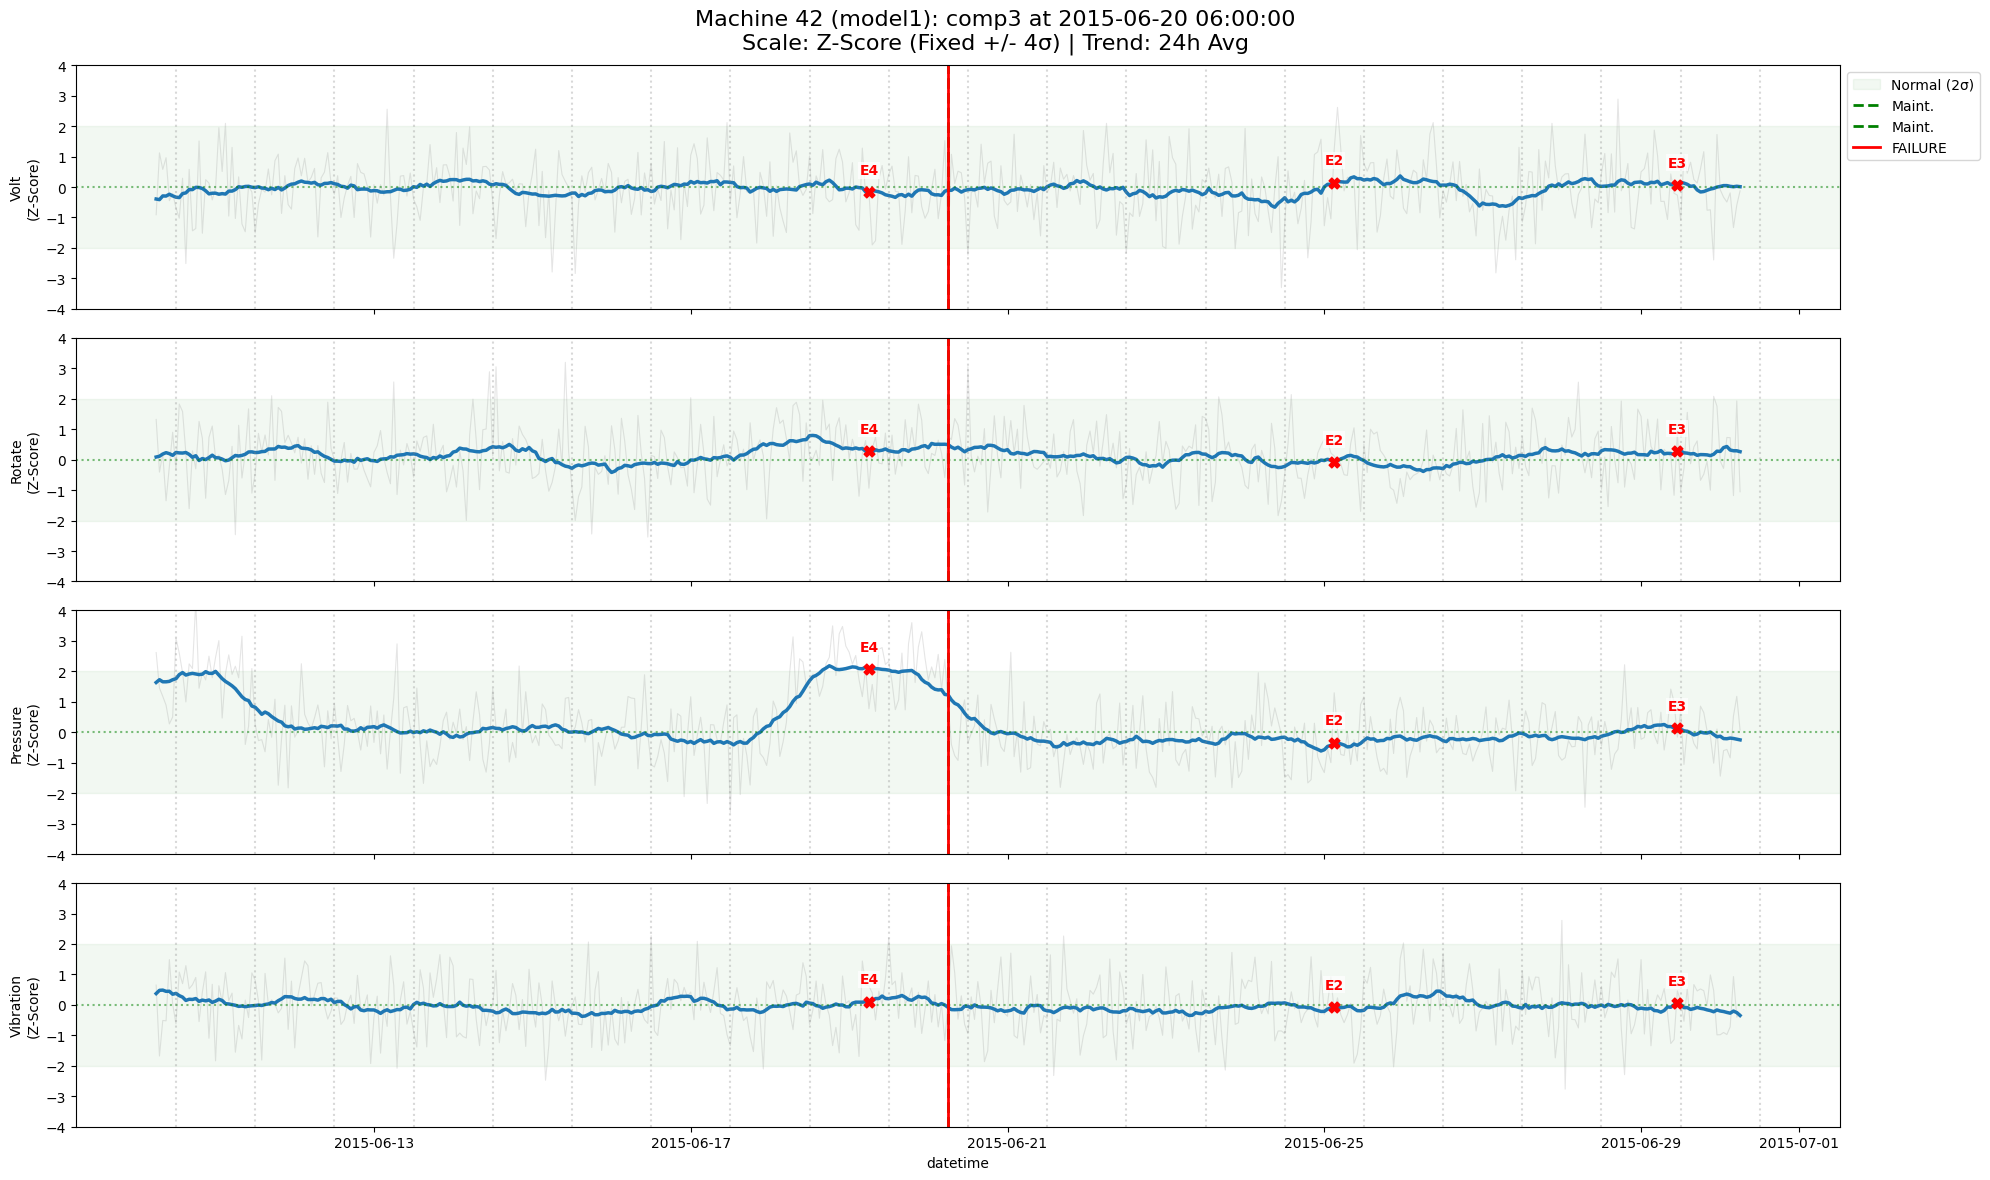



=== Visualizing for model1 - comp4 ===
Loading data...


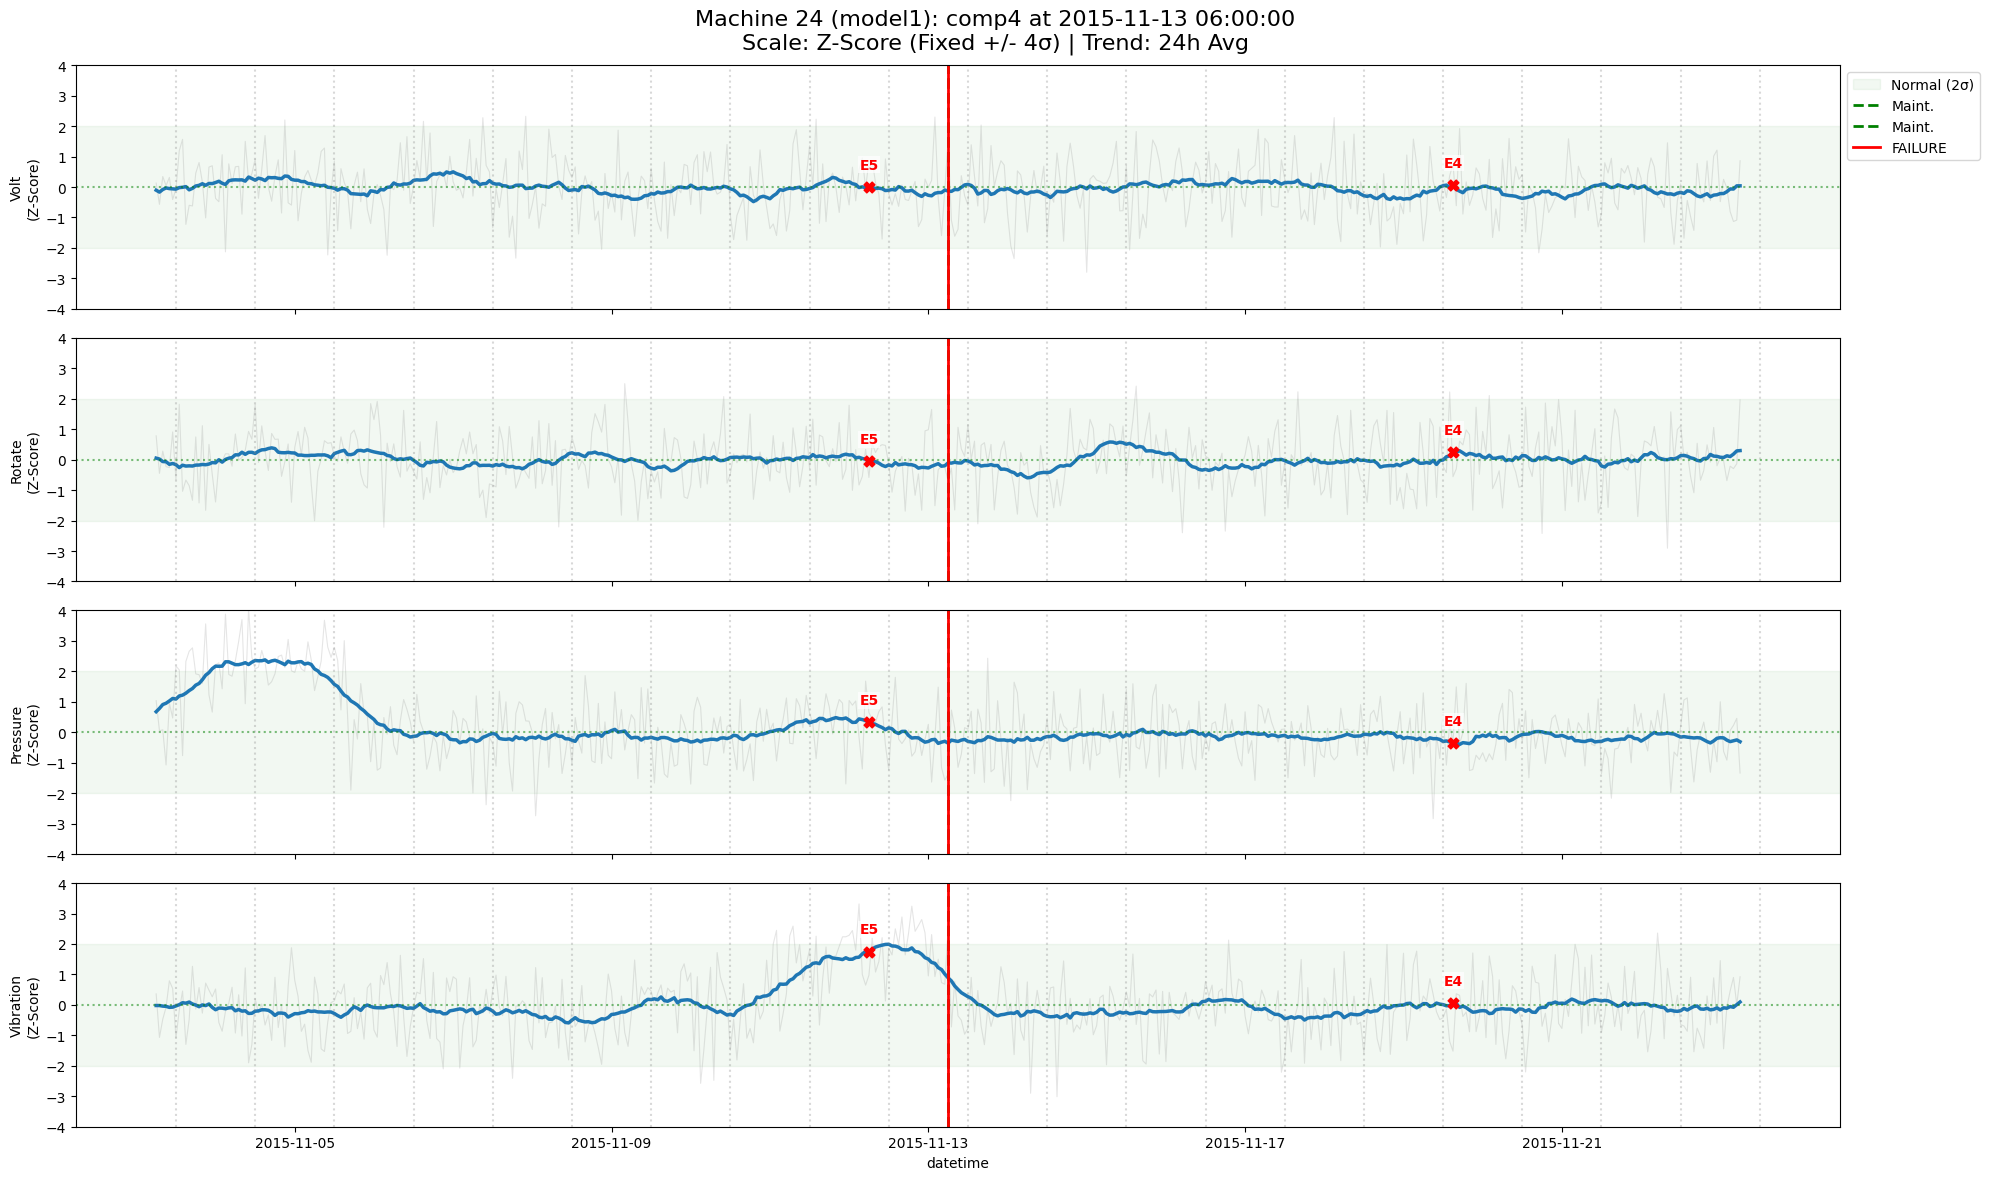



=== Visualizing for model2 - comp1 ===
Loading data...


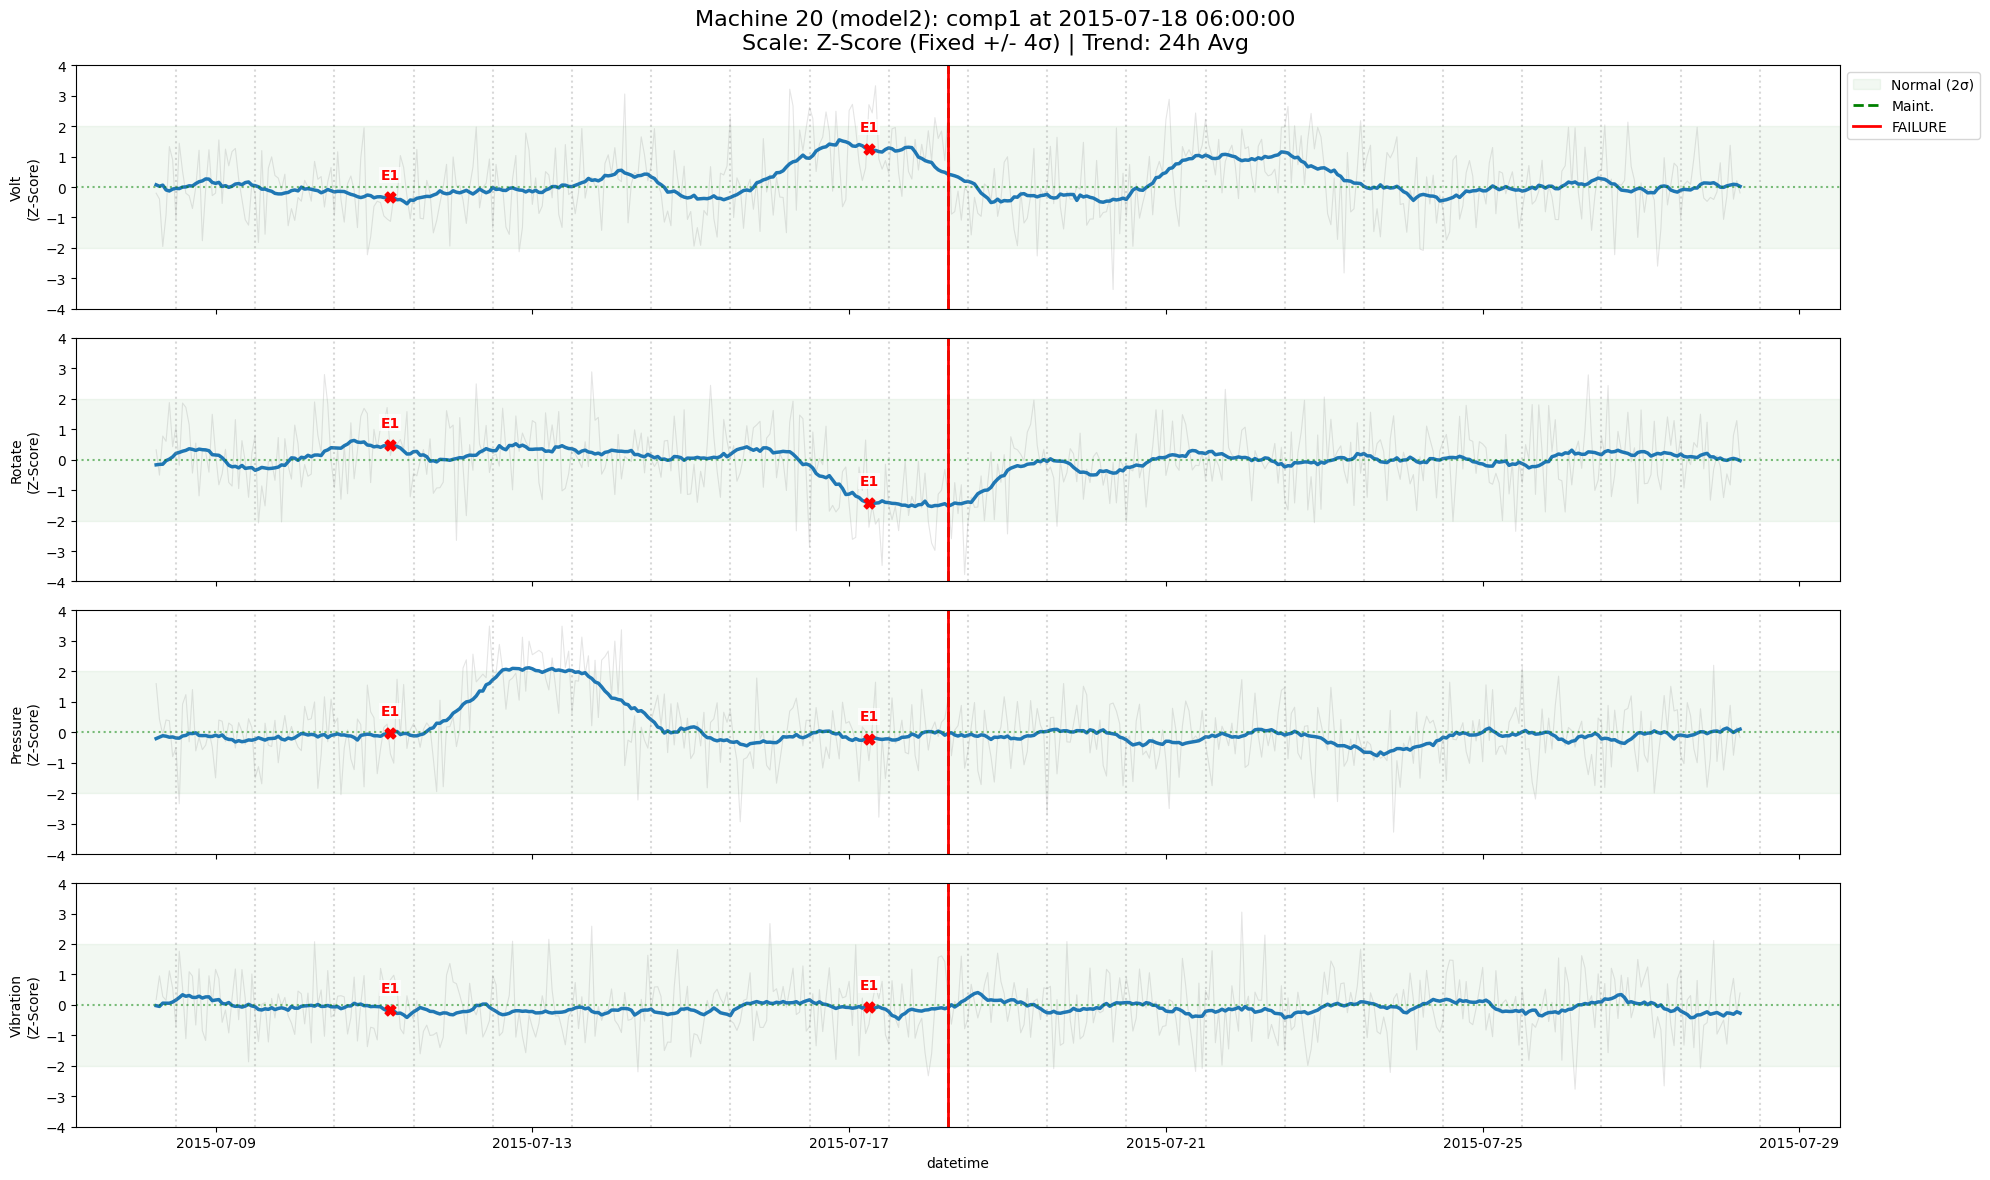



=== Visualizing for model2 - comp2 ===
Loading data...


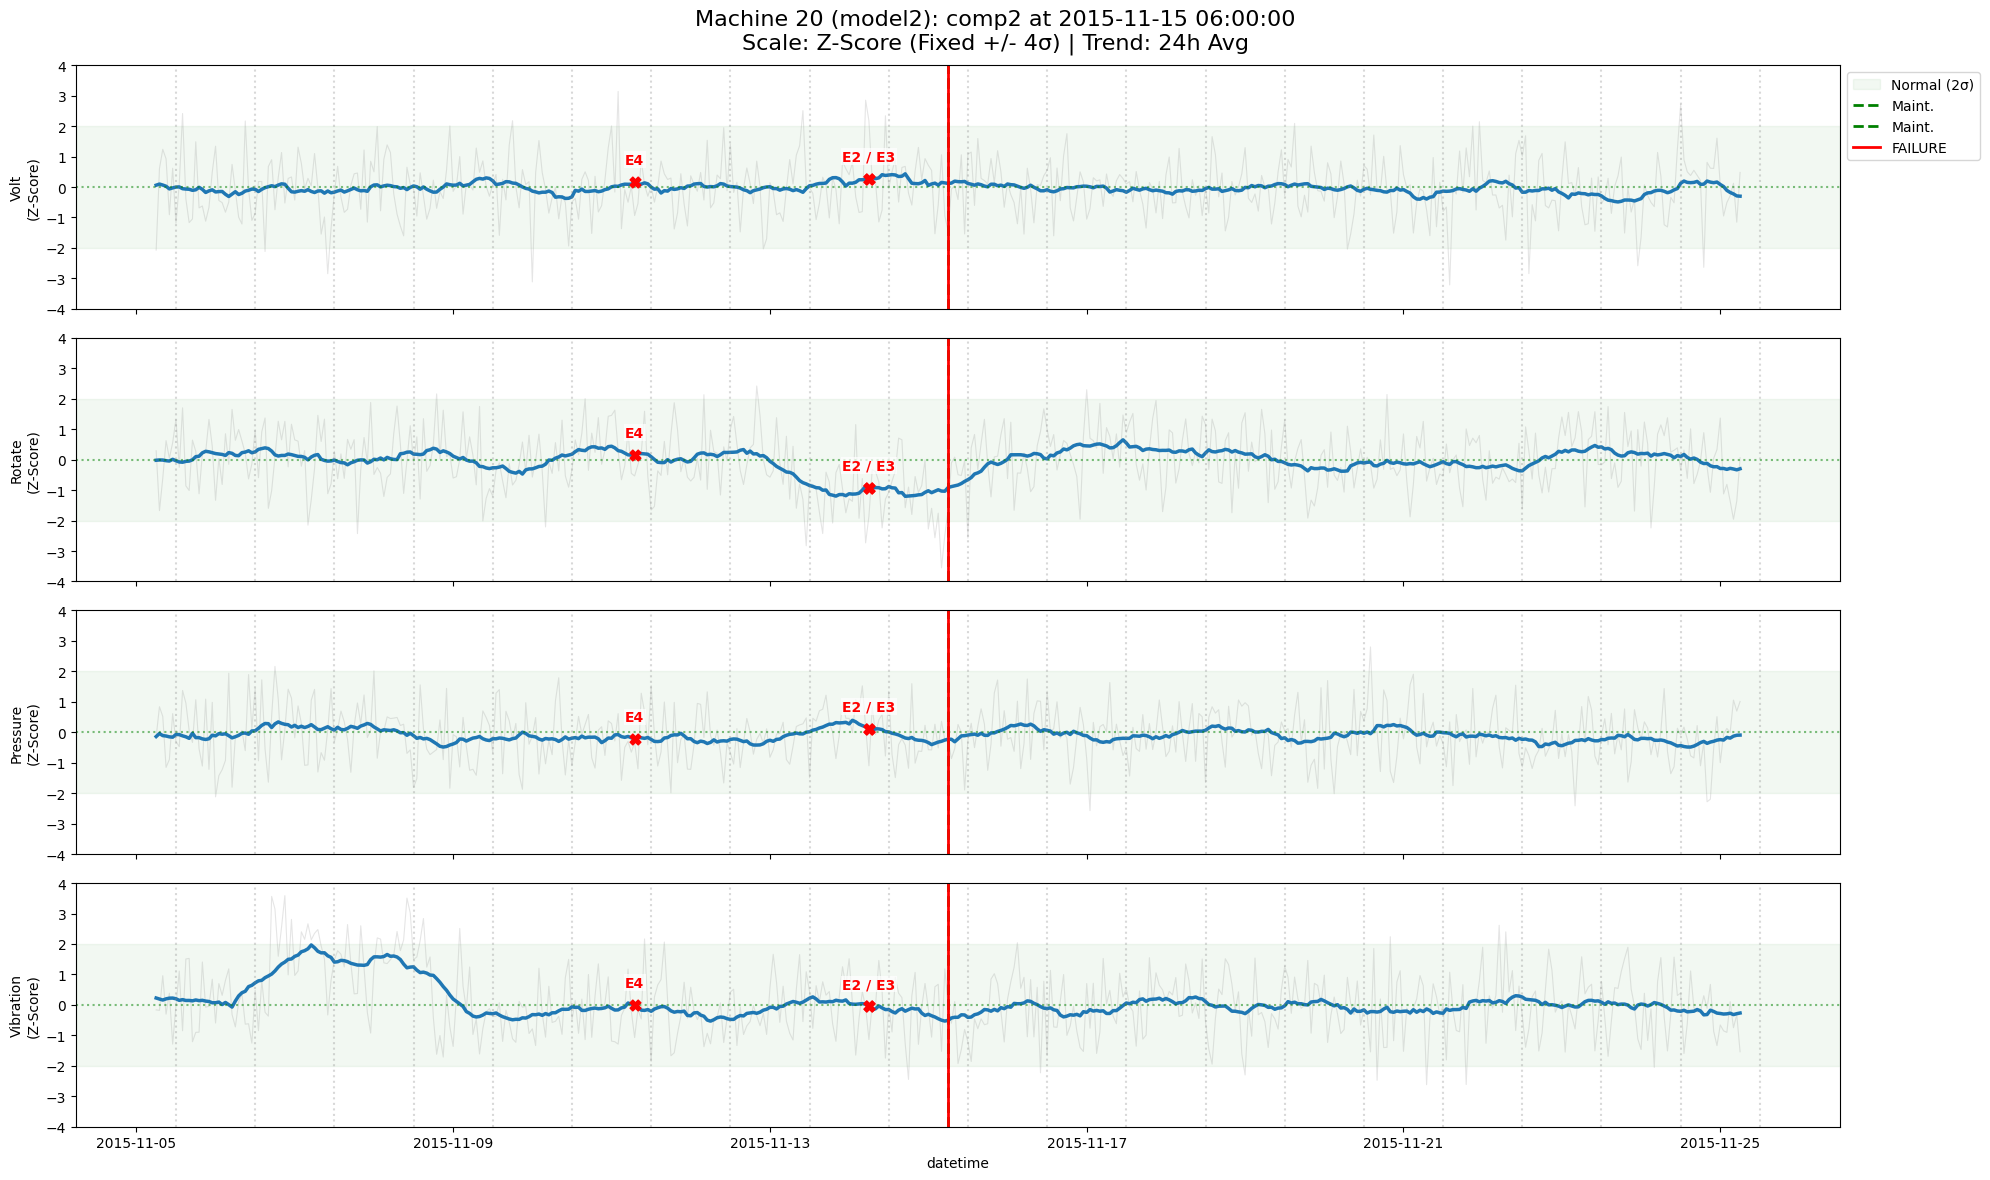



=== Visualizing for model2 - comp3 ===
Loading data...


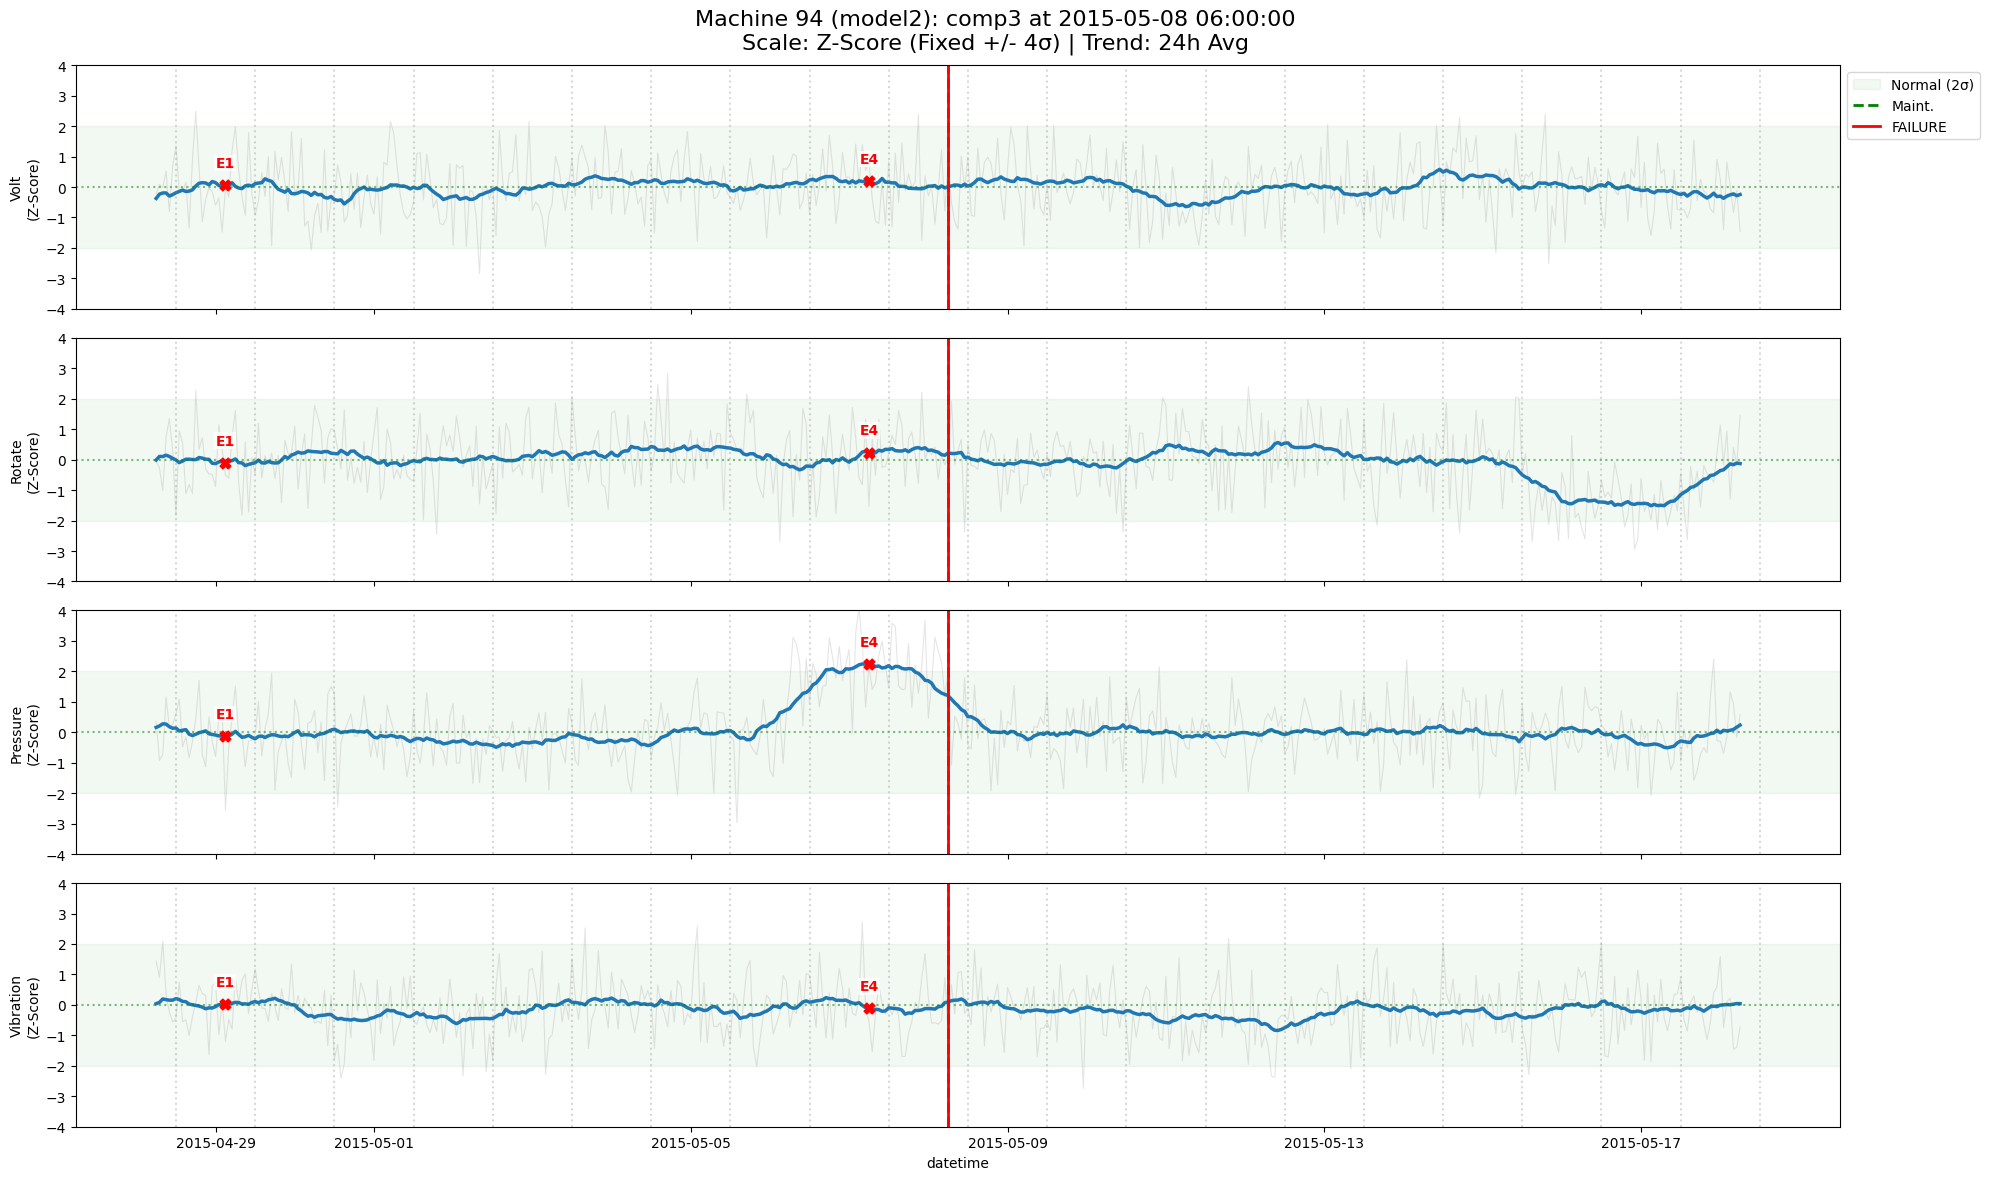



=== Visualizing for model2 - comp4 ===
Loading data...


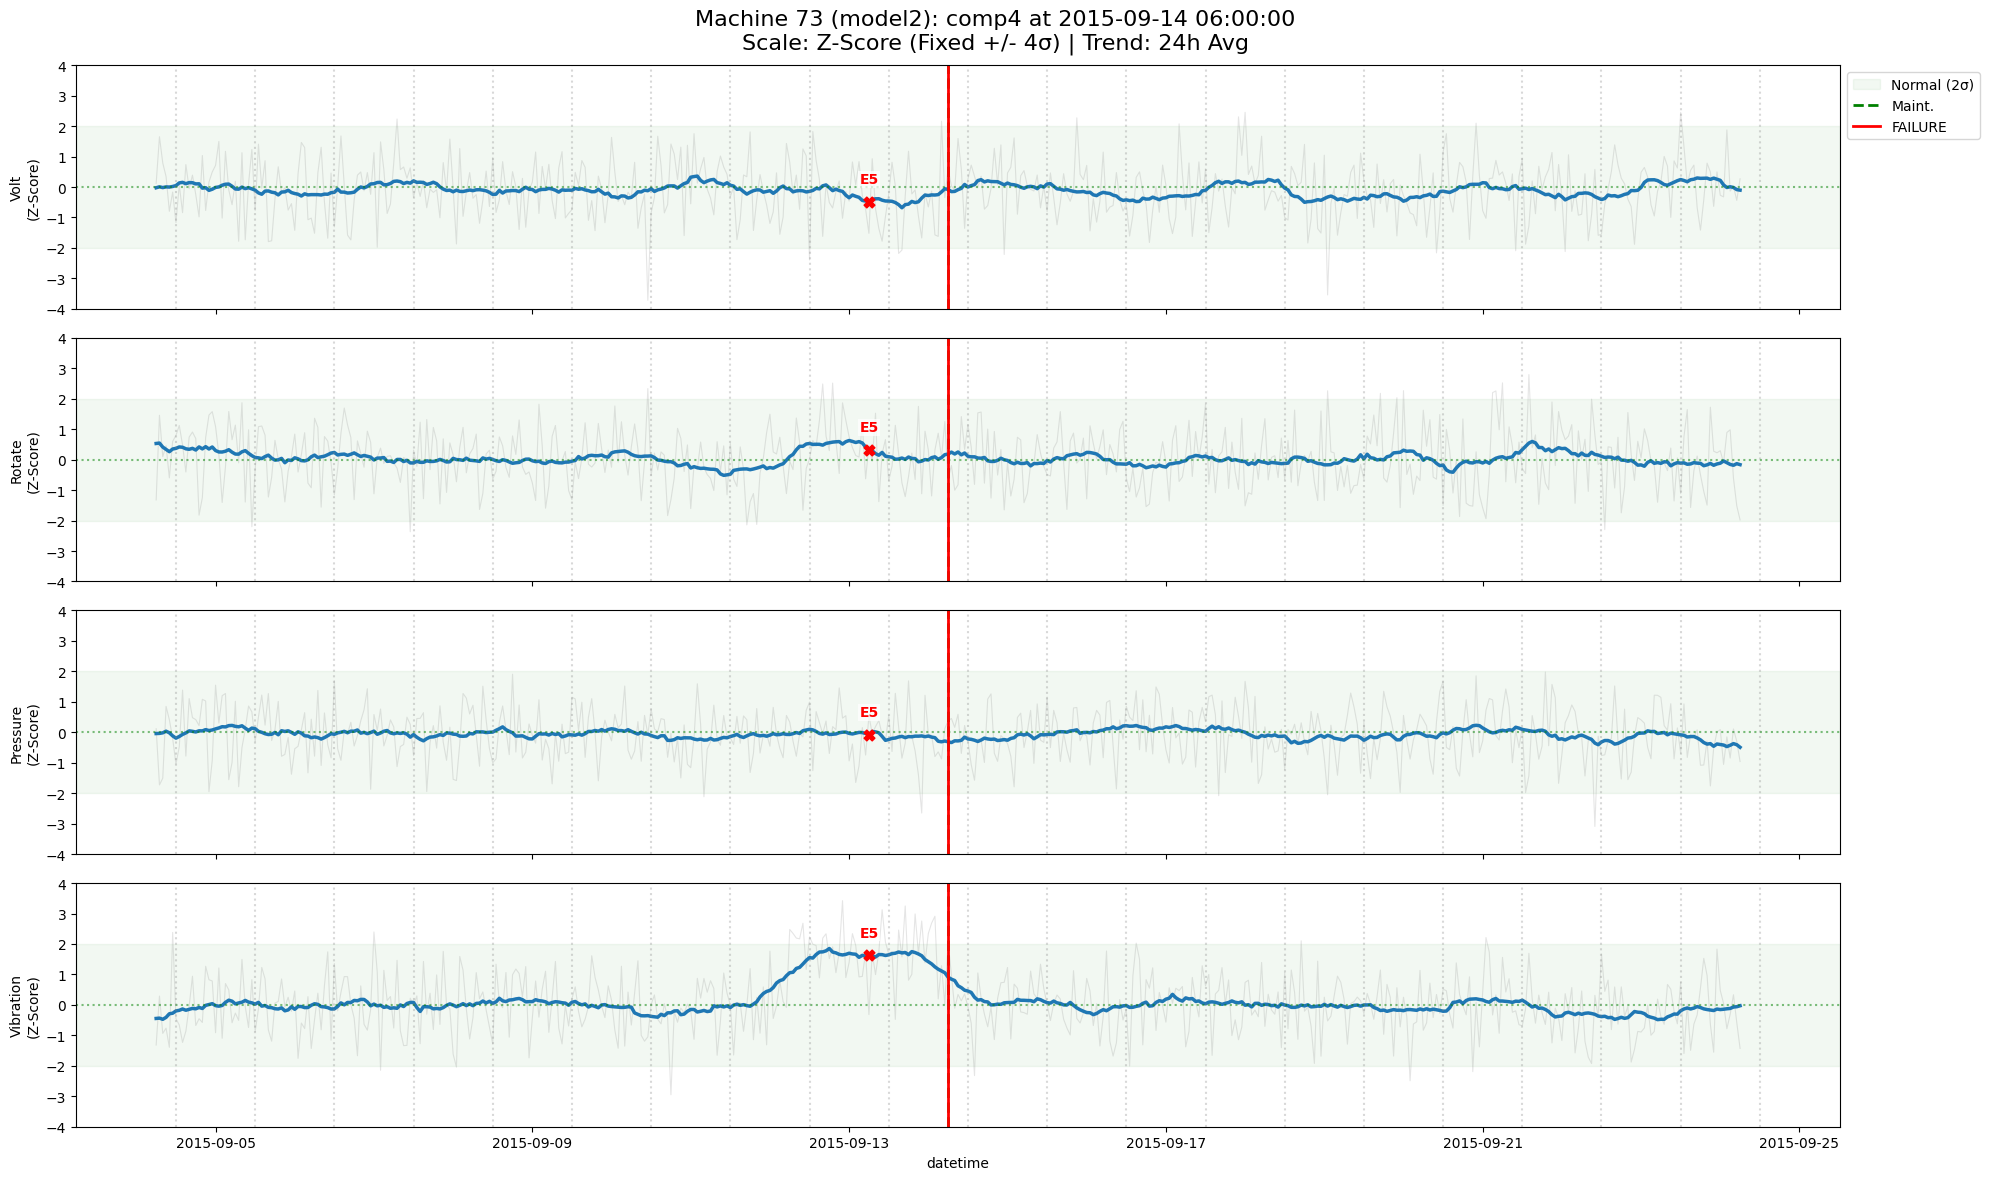



=== Visualizing for model3 - comp1 ===
Loading data...


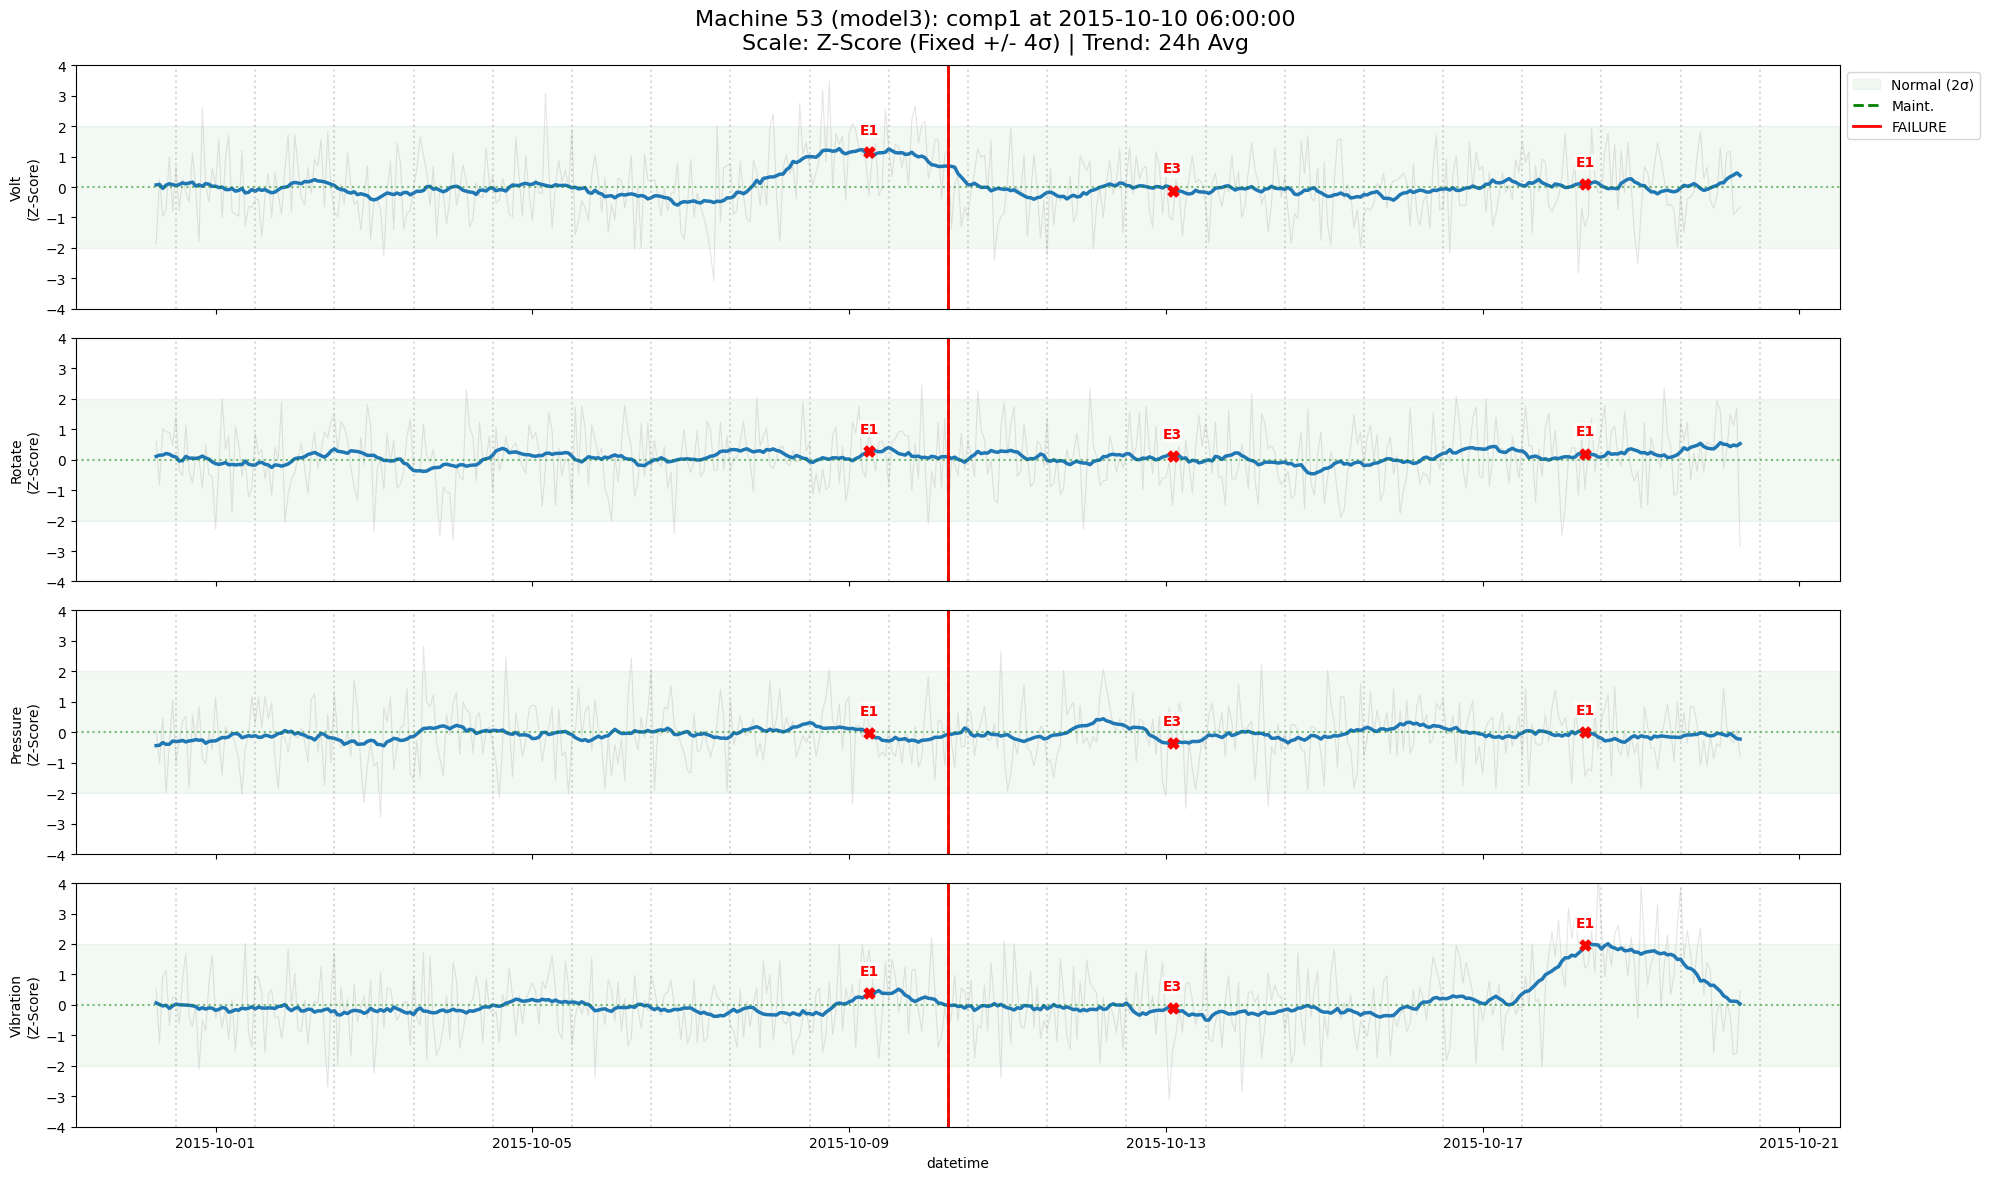



=== Visualizing for model3 - comp2 ===
Loading data...


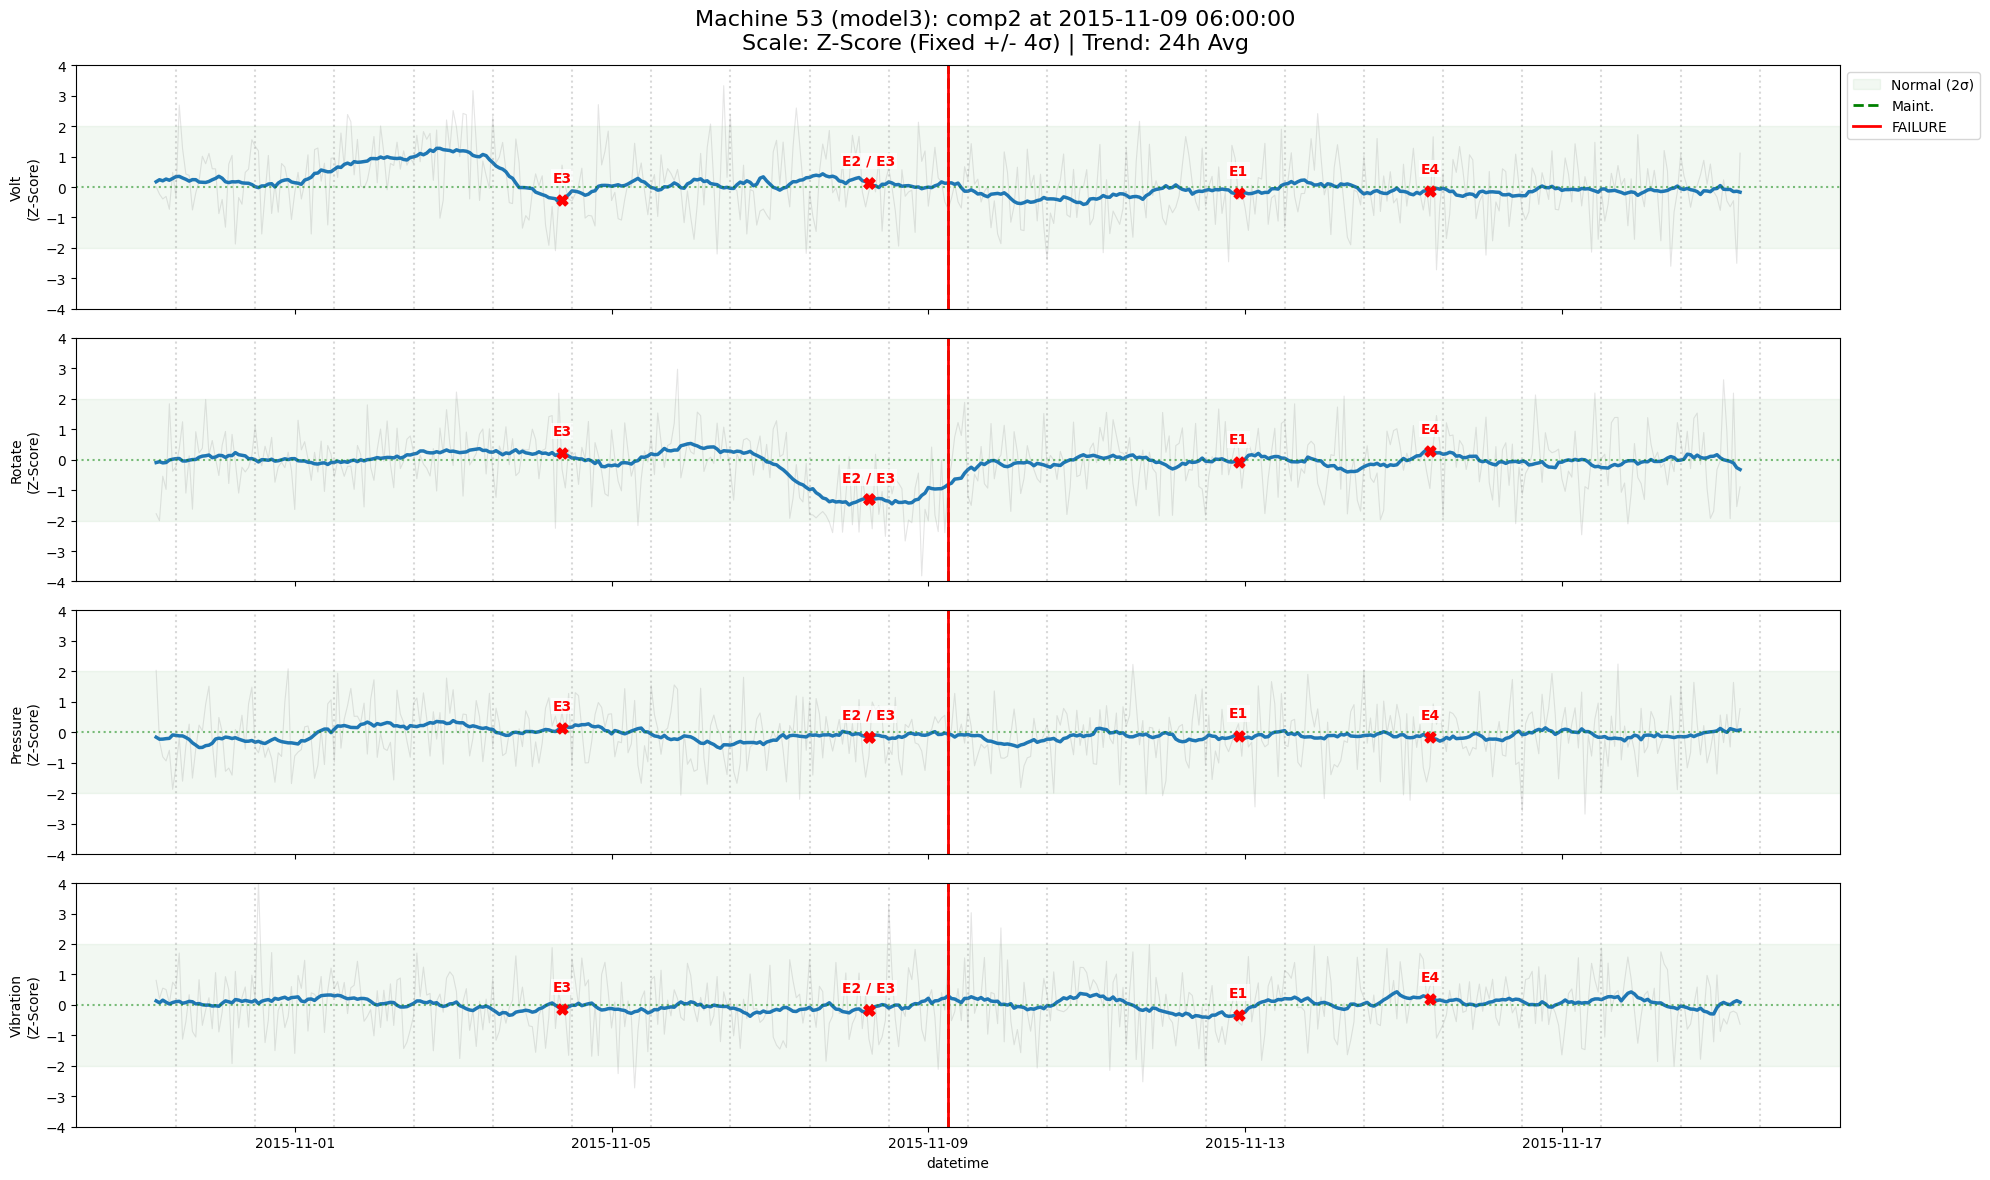



=== Visualizing for model3 - comp3 ===
Loading data...
No failures found.


=== Visualizing for model3 - comp4 ===
Loading data...


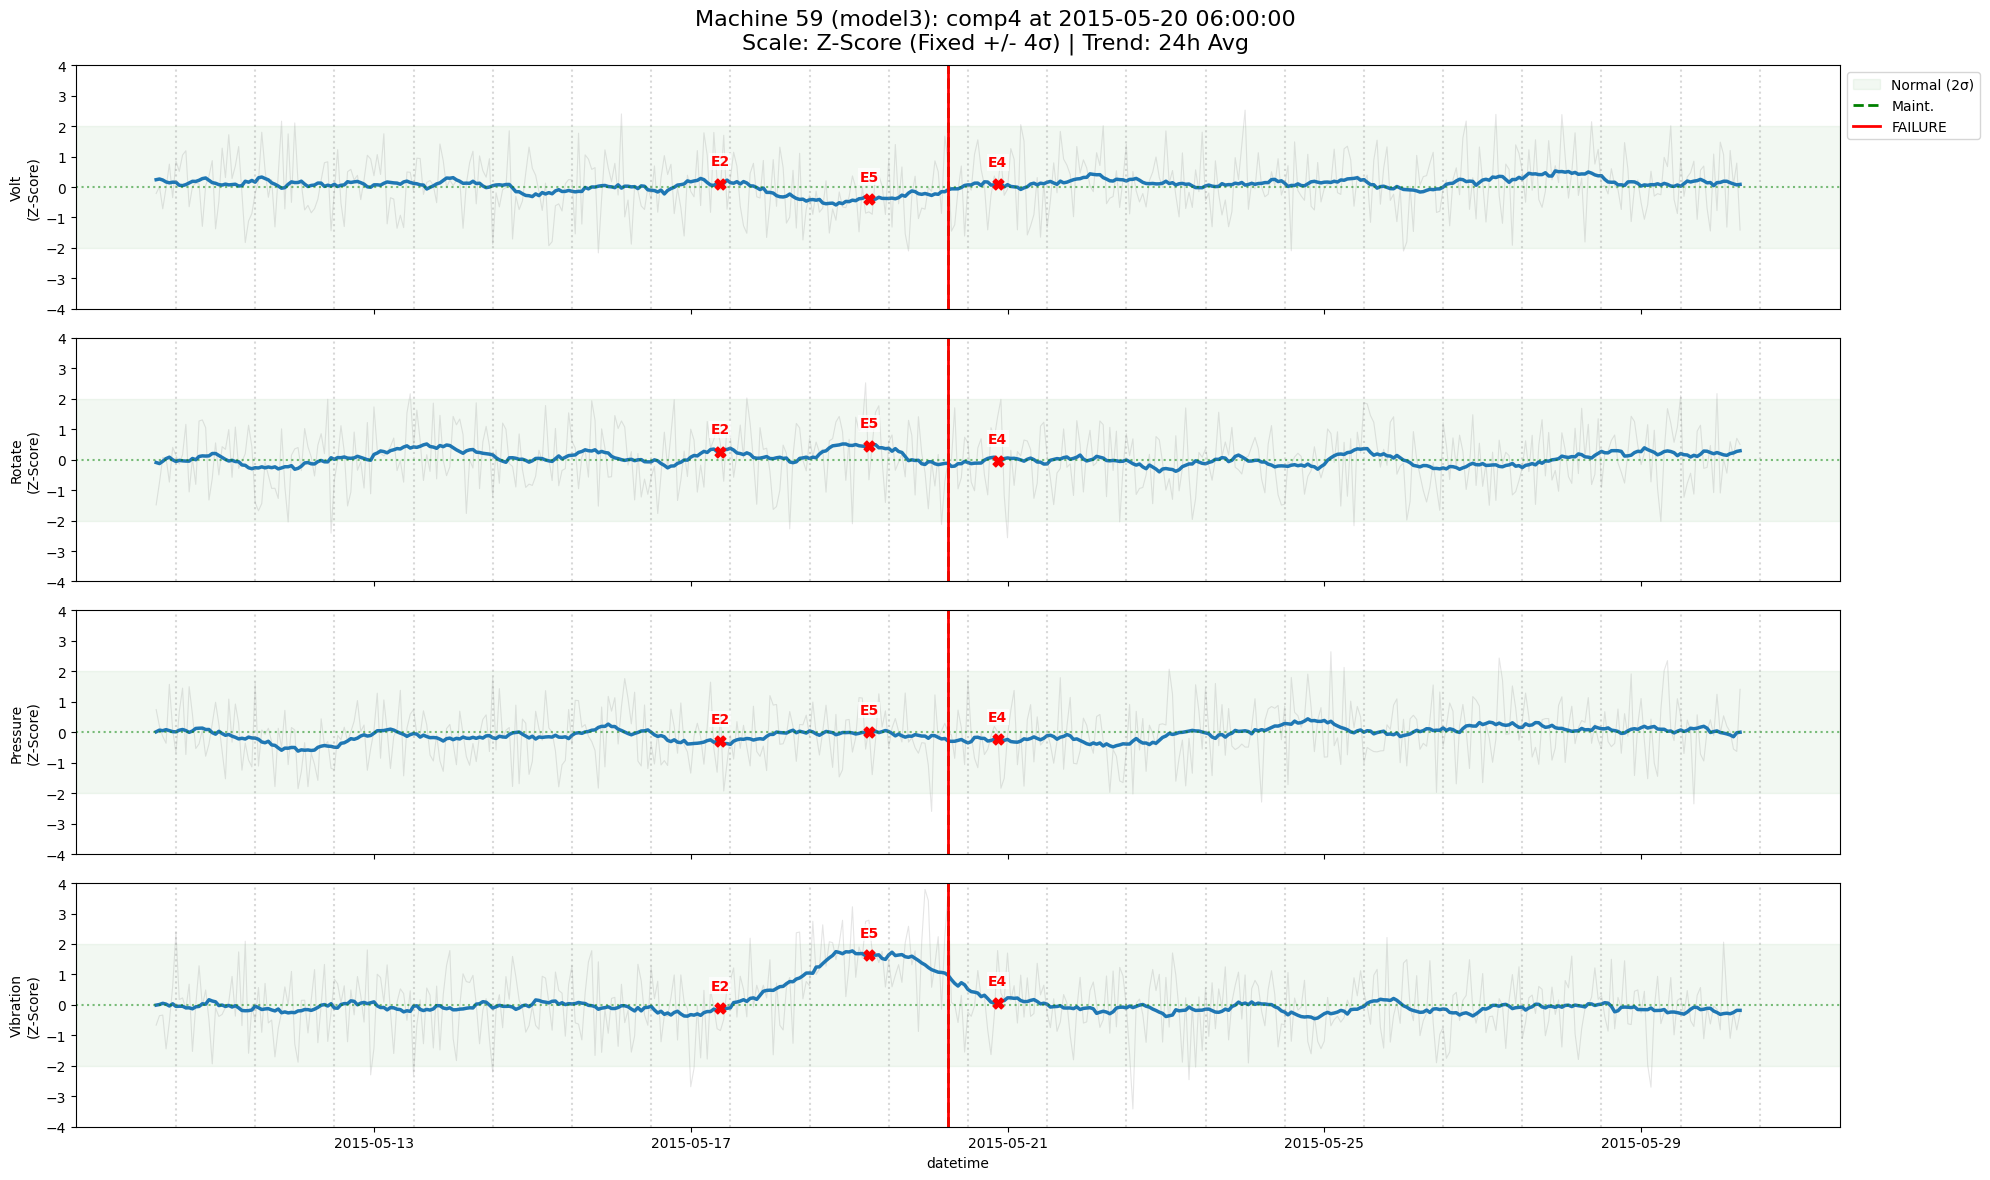



=== Visualizing for model4 - comp1 ===
Loading data...


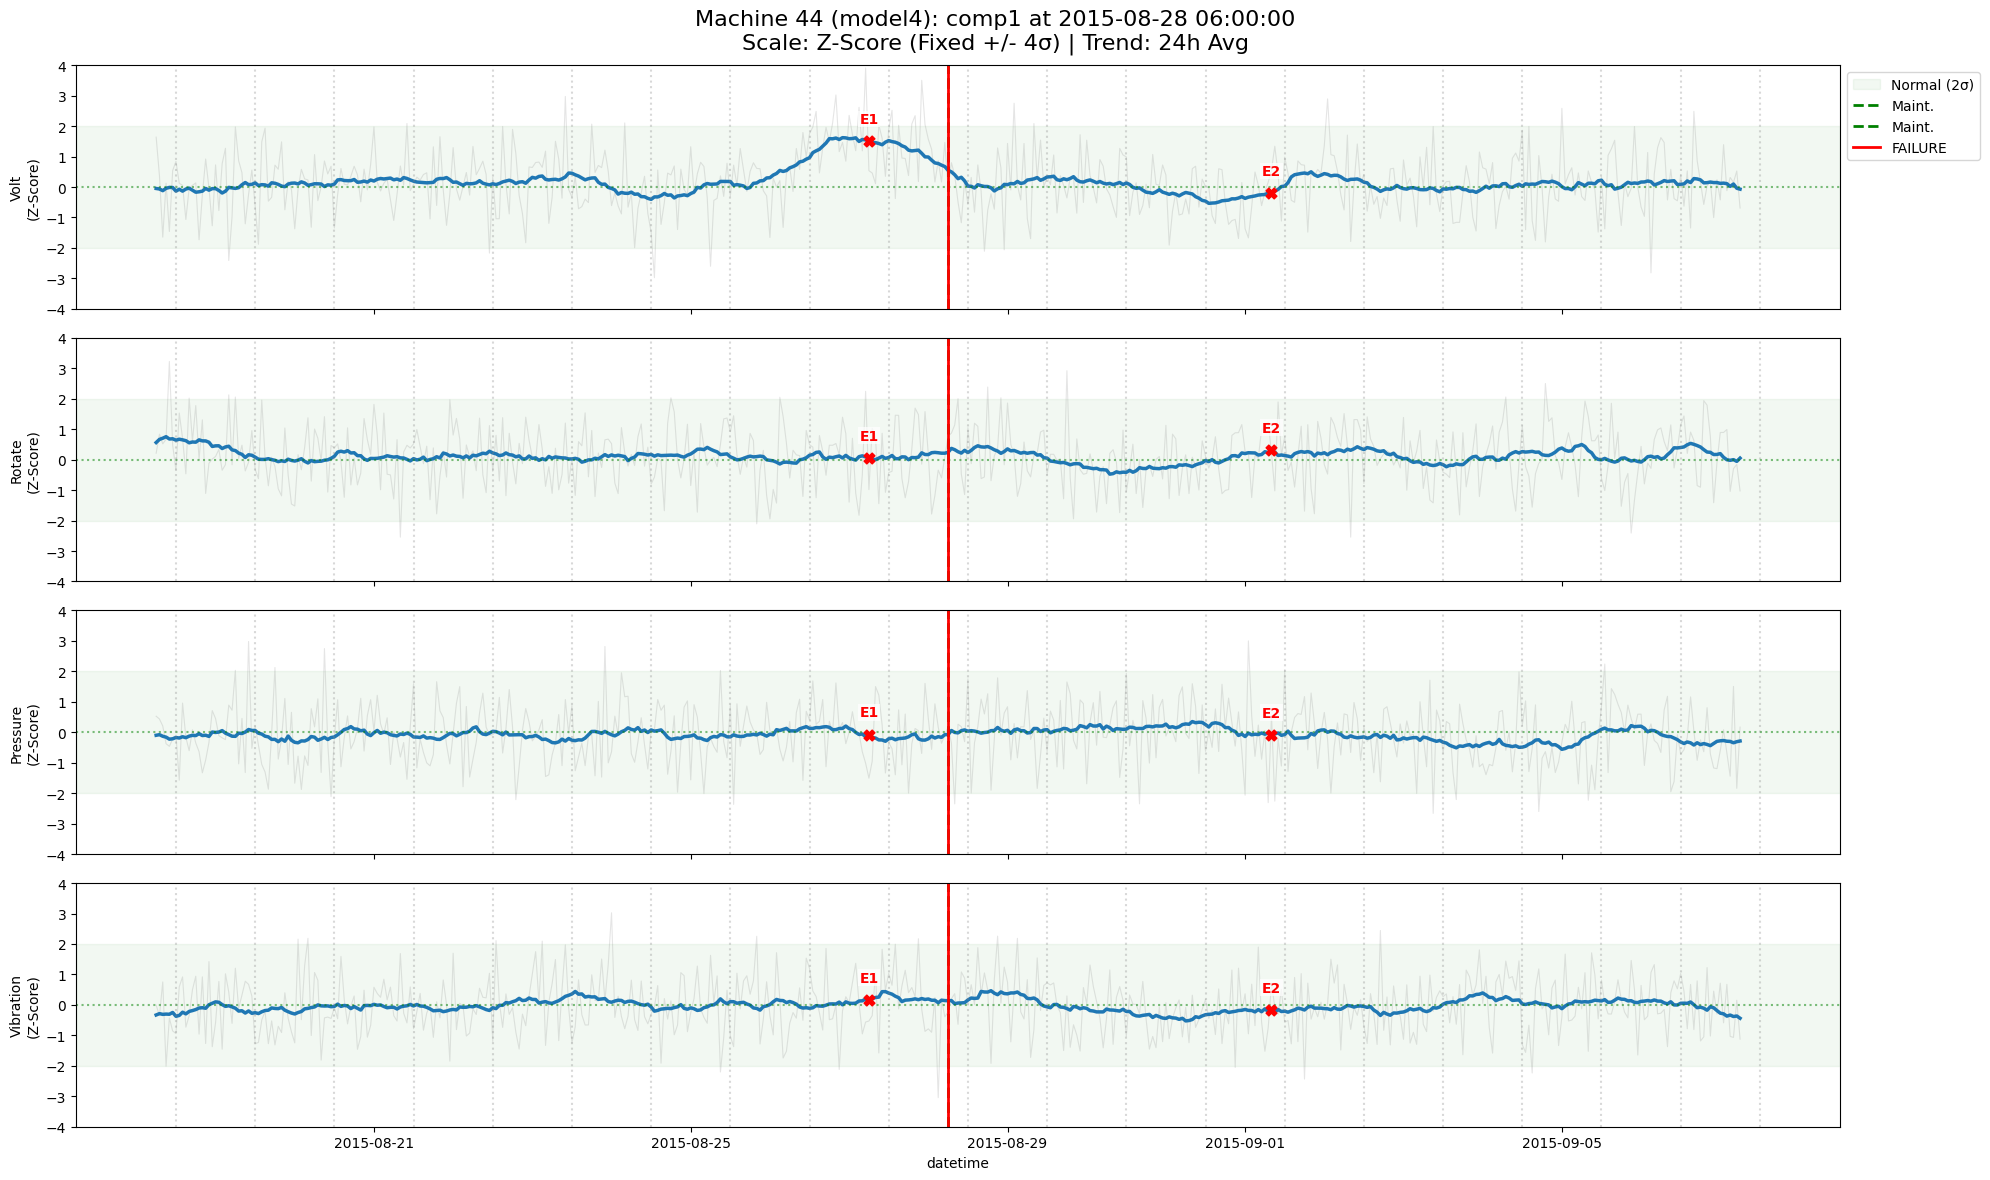



=== Visualizing for model4 - comp2 ===
Loading data...


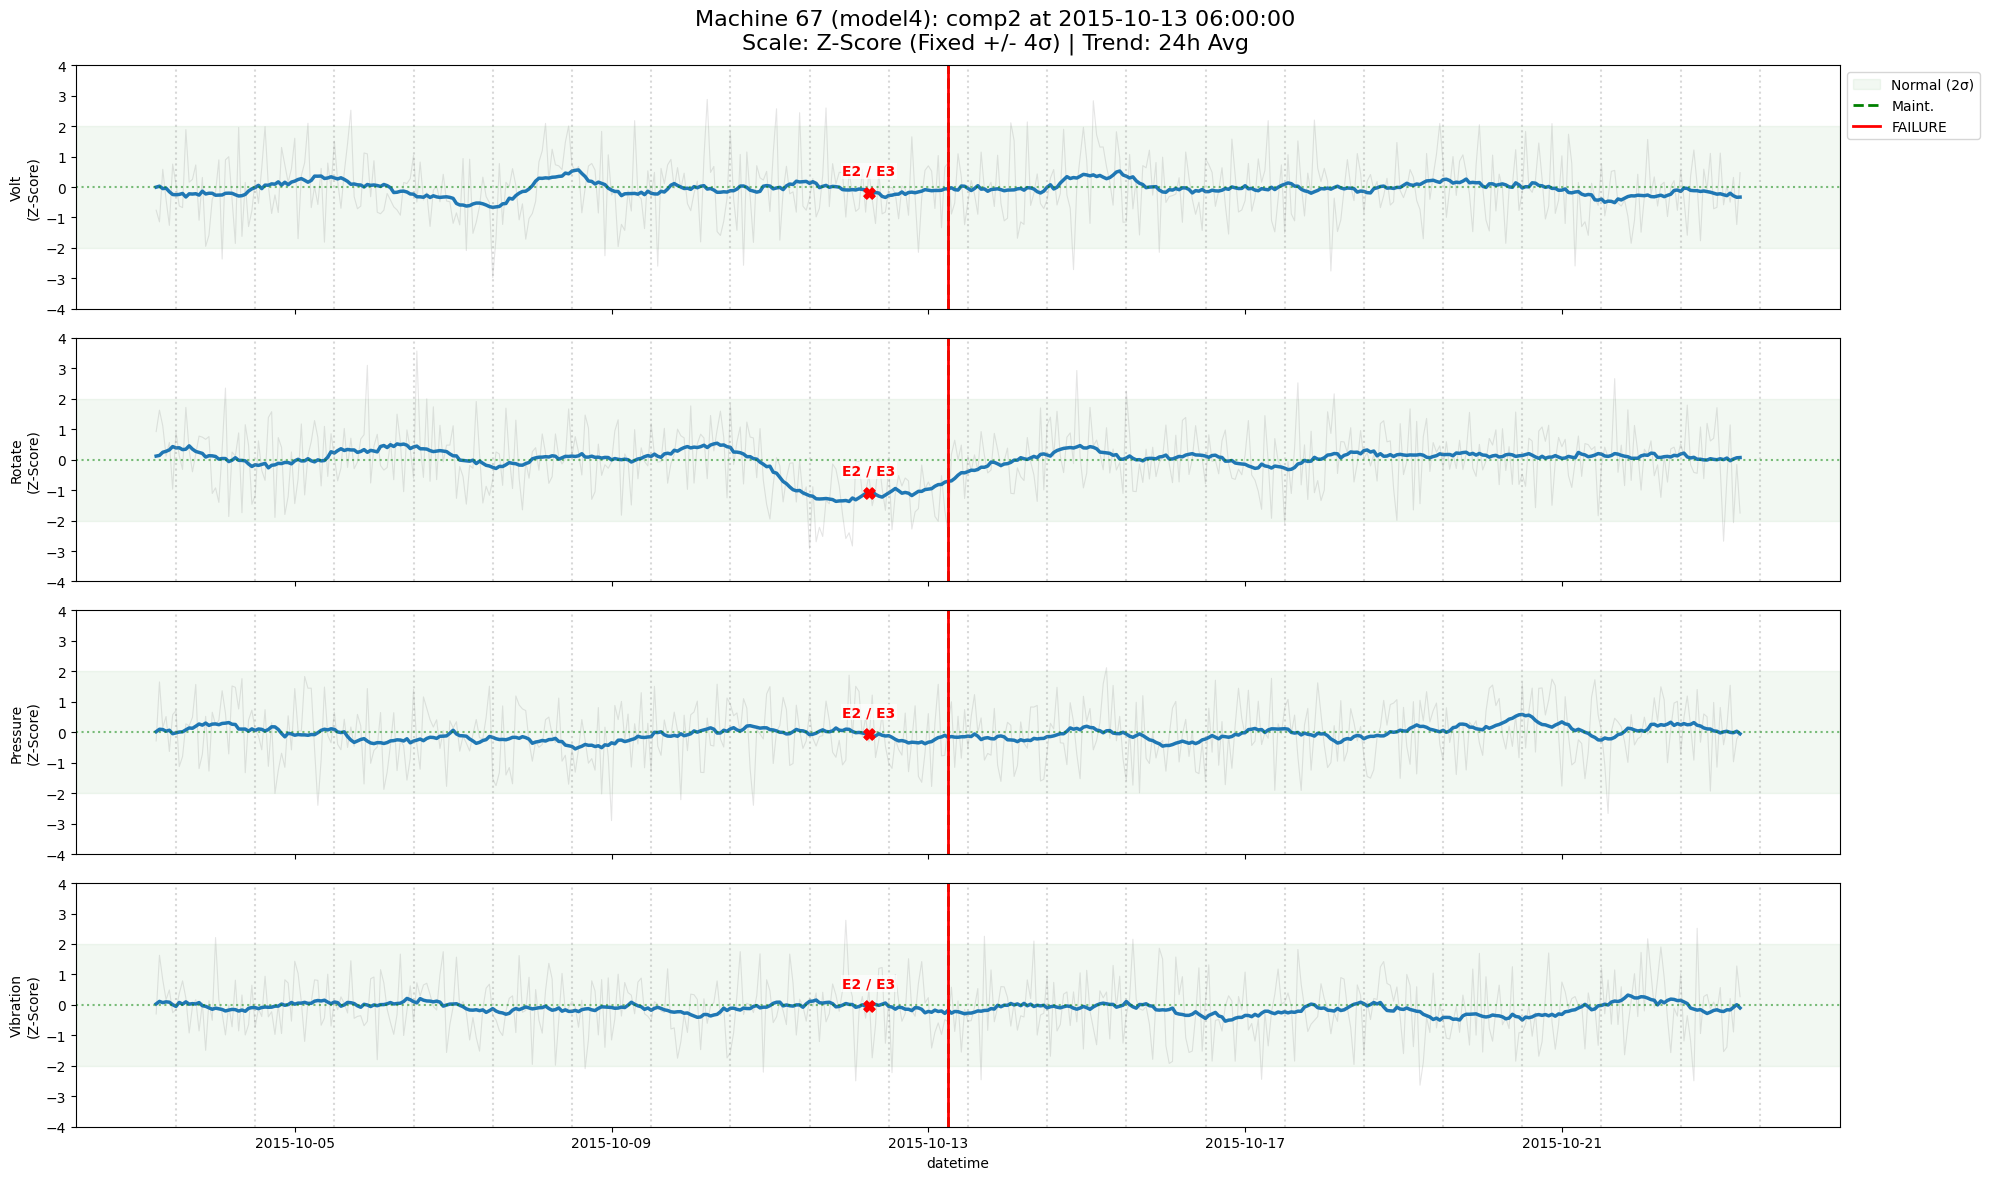



=== Visualizing for model4 - comp3 ===
Loading data...
No failures found.


=== Visualizing for model4 - comp4 ===
Loading data...


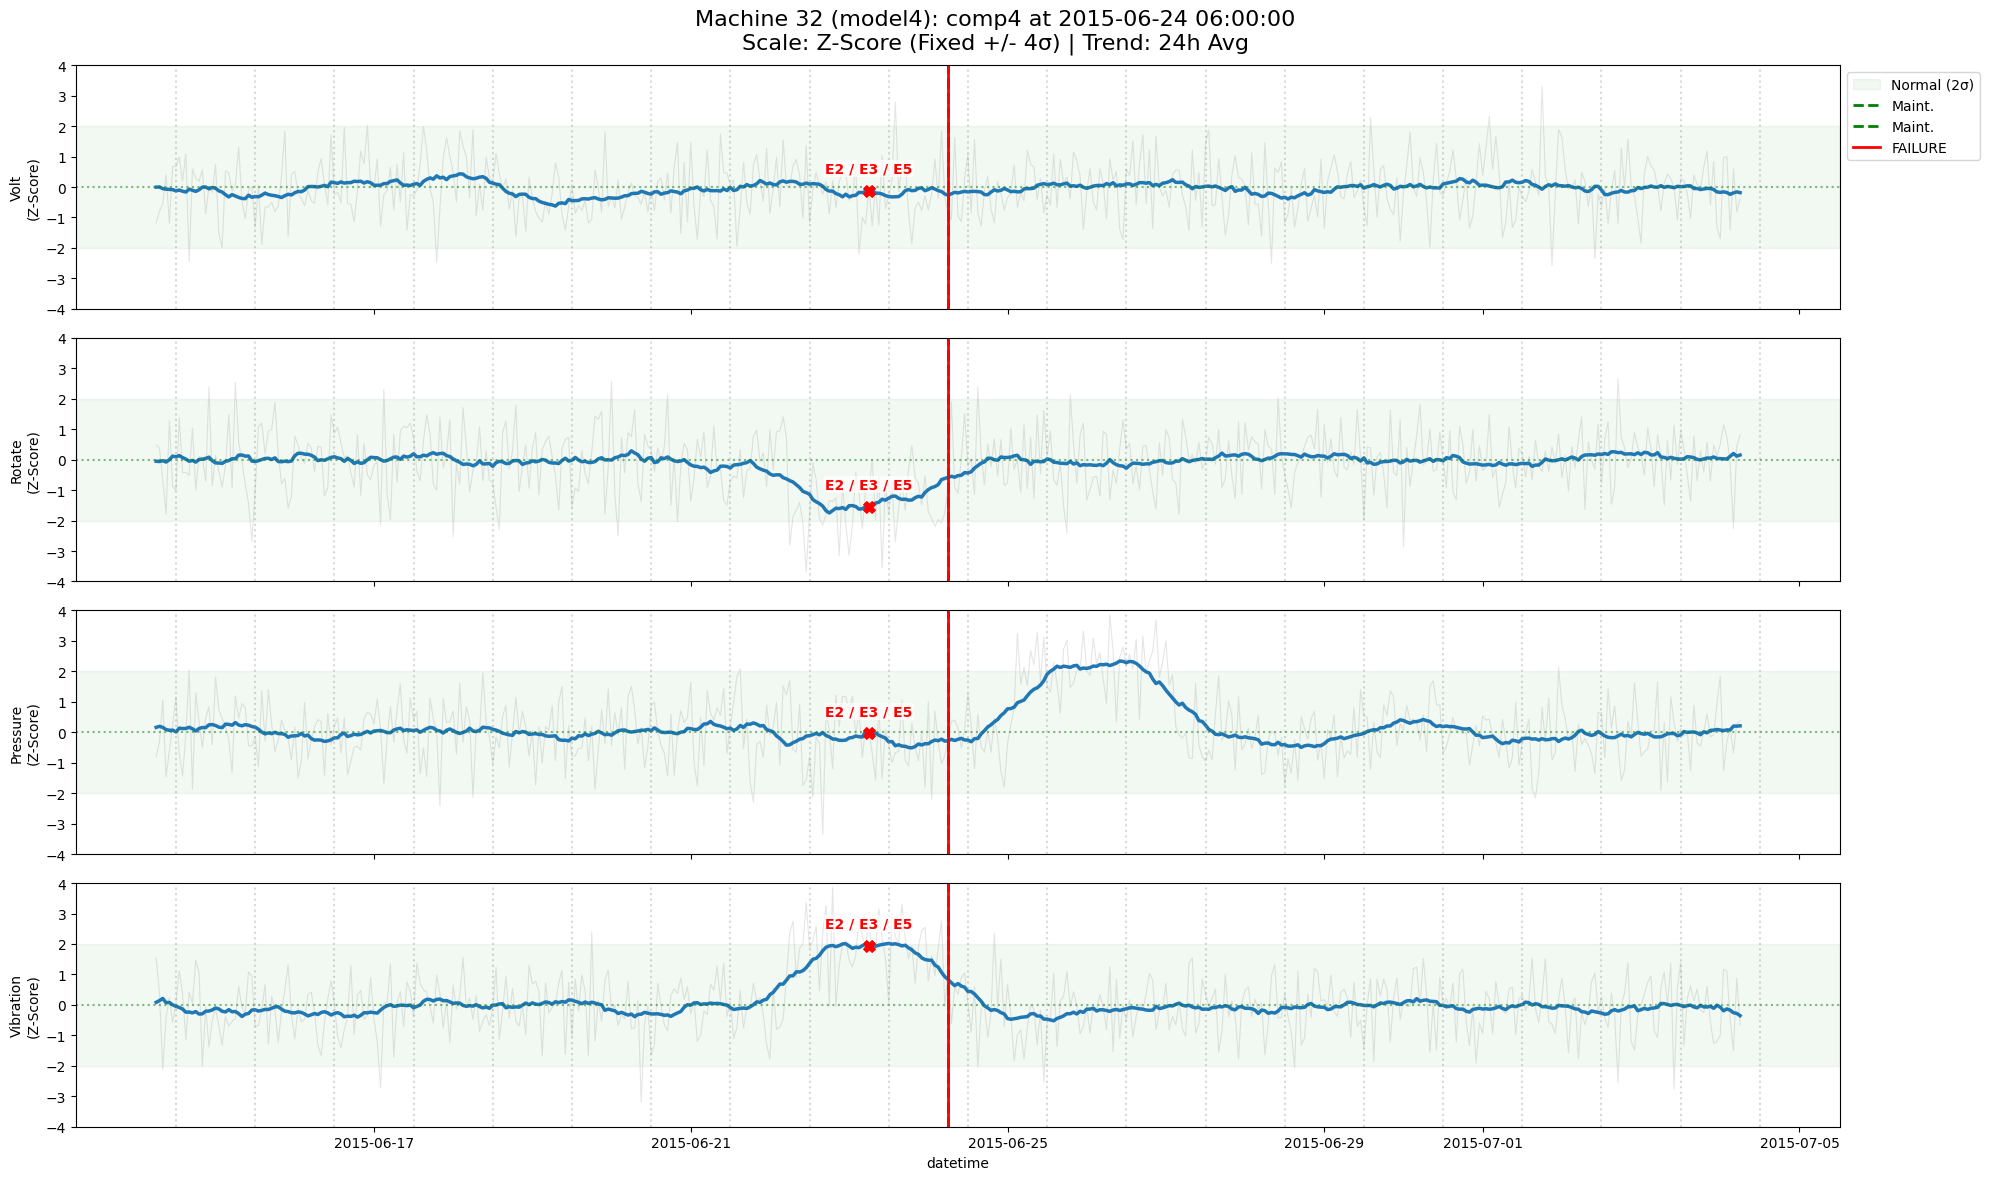

In [10]:
for model_type in ["model1", "model2", "model3", "model4"]:
    for failure_type in ["comp1", "comp2", "comp3", "comp4"]:
        print(f"\n\n=== Visualizing for {model_type} - {failure_type} ===")
        visualize_data(
            telemetry_path="./data/PdM_telemetry.csv",
            errors_path="./data/PdM_errors.csv",
            failures_path="./data/PdM_failures.csv",
            maint_path="./data/PdM_maint.csv",
            machines_path="./data/PdM_machines.csv",
            machine_model=model_type,
            failure_type=failure_type,
            window_hours=240,
            n_examples=1,
            ylim_sigma=4,
            smooth_window=24,
            scale=True
        )

In [21]:
from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.regressionCI import RegressionCI  # mixed data CI test


def run_pcmciplus_pdm_subset(
    merged: pd.DataFrame,
    model_value: str,
    machine_ids=None,
    tau_max: int = 24,
    pc_alpha: float = 0.05,
    fdr_method: str = "fdr_bh",
    verbosity: int = 1,
):
    """
    Runs PCMCI+ on a small subset: one model type, a few machines (realizations).

    Uses RegressionCI, a parametric CI test that supports continuous/categorical/mixed data,
    but requires data_type to be provided in the Tigramite DataFrame. :contentReference[oaicite:2]{index=2}
    """

    # --- 1) Filter to one model type
    df = merged[merged["model"] == model_value].copy()
    if df.empty:
        raise ValueError(f"No rows found for model={model_value!r}")

    # --- 2) Pick 3 machines if not provided
    all_machines = np.sort(df["machineID"].unique())
    if machine_ids is None:
        machine_ids = all_machines[:3] # TEMPORARY
    else:
        machine_ids = list(machine_ids)

    df = df[df["machineID"].isin(machine_ids)].copy()
    if df.empty:
        raise ValueError("No rows after filtering to selected machine_ids.")

    # --- 3) Choose variables (telemetry + errors + maint + failures + age)
    telemetry_cols = [c for c in ["volt", "rotate", "pressure", "vibration"] if c in df.columns]
    error_cols     = [c for c in df.columns if c.startswith("error")]
    maint_cols     = [c for c in df.columns if c.startswith("maint_")]
    fail_cols      = [c for c in df.columns if c.startswith("fail_")]
    age_cols       = ["age"] if "age" in df.columns else []

    var_names = telemetry_cols + age_cols + error_cols + maint_cols + fail_cols

    # Drop columns that are constant across ALL samples in this subset (important for CI tests)
    nunique = df[var_names].nunique(dropna=False)
    var_names = [c for c in var_names if nunique[c] > 1]
    if len(var_names) < 2:
        raise ValueError("Too few non-constant variables after filtering.")

    # --- 4) Define variable types for RegressionCI: 0=continuous, 1=discrete :contentReference[oaicite:3]{index=3}
    # Continuous: telemetry + age (already scaled by you)
    cont_set = set(telemetry_cols + age_cols)
    var_types_1d = np.array([0 if v in cont_set else 1 for v in var_names], dtype=np.int8)

    # --- 5) Build Tigramite 'multiple datasets' inputs (dict: machineID -> (T,N) array)
    data_dict = {}
    dtype_dict = {}

    # Ensure each machine is a clean hourly series, aligned by its own datetime index
    for mid in machine_ids:
        sub = df[df["machineID"] == mid].sort_values("datetime")
        # (Telemetry is hourly complete, but if your merge introduces gaps, fill them here)
        sub = sub.set_index("datetime")[var_names]
        # If there are missing hours, uncomment reindex:
        # full_idx = pd.date_range(sub.index.min(), sub.index.max(), freq="H")
        # sub = sub.reindex(full_idx).fillna(0)

        X = sub.to_numpy()
        data_dict[str(mid)] = X

        # data_type must match shape of the data array for RegressionCI :contentReference[oaicite:4]{index=4}
        dtype_dict[str(mid)] = np.tile(var_types_1d, (X.shape[0], 1))

    # --- 6) Create Tigramite DataFrame in multiple-datasets mode :contentReference[oaicite:5]{index=5}
    tdf = DataFrame(
        data=data_dict,
        data_type=dtype_dict,
        analysis_mode="multiple",
        var_names=var_names,
    )

    # --- 7) Run PCMCI+
    # RegressionCI supports mixed data via linear / multinomial regression internally :contentReference[oaicite:6]{index=6}
    cond_test = RegressionCI()

    pcmci = PCMCI(dataframe=tdf, cond_ind_test=cond_test, verbosity=verbosity)
    results = pcmci.run_pcmciplus(tau_max=tau_max, pc_alpha=pc_alpha)

    # PCMCI+ output graph encoding notes (directed lagged links are time-ordered; tau=0 can be partially oriented) :contentReference[oaicite:7]{index=7}
    graph = results["graph"]
    p_matrix = results["p_matrix"]
    val_matrix = results["val_matrix"]

    # Optional: FDR correction (q-values)
    if fdr_method and fdr_method != "none":
        q_matrix = pcmci.get_corrected_pvalues(p_matrix=p_matrix, tau_max=tau_max, fdr_method=fdr_method)
    else:
        q_matrix = None

    # Print significant links (uses p_matrix; you can swap in q_matrix if you want FDR-controlled reporting)
    pcmci.print_significant_links(
        p_matrix=(q_matrix if q_matrix is not None else p_matrix),
        val_matrix=val_matrix,
        alpha_level=pc_alpha,
    )

    return {
        "pcmci": pcmci,
        "results": results,
        "q_matrix": q_matrix,
        "var_names": var_names,
        "machine_ids": machine_ids,
    }


In [22]:
    
out = run_pcmciplus_pdm_subset(
    merged=df,
    model_value="model1",
    machine_ids=None,     # auto-picks first 3 machines of model1
    tau_max=24,            # start small
    pc_alpha=0.05,
    fdr_method="fdr_bh",
    verbosity=1,
)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = regression_ci
tau_min = 1
tau_max = 24
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1




KeyboardInterrupt: 